# Import the Packages and Survey Data

In [10]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing
from scipy import stats as st
from pandas.plotting import scatter_matrix
import xarray as xr
import seaborn as sns

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Necessary Functions

In [11]:
# Necessary Functions
def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

def db_with_limits(data, limit_low=-75, limit_high=0): # Function for numpy arrays
    data = db(data)
    data[data>limit_high] = limit_high
    data[data<limit_low] = limit_low
    return data

def xr_db_with_limits(xarr, limit_low=-75, limit_high=0): # Function to be applied to xarray dataarray
    data = db(xarr)
    result = data.where((data<limit_high) | (data.isnull()), limit_high)
    result = result.where((result>limit_low) | (result.isnull()), limit_low)
    return result

# Example Illustration for a patch - Echogram, annotations, Background Sv Distribution
def examp_illustr(survey, x, y, fig_start=-75, fig_finish=5, s_bin=5, db_w_limit=True, patch_size=[256, 256]):
    
    c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=True)
    if db_w_limit:
        a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                                    idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                    return_numpy=False, frequencies=[38000]))
        echo = a[0,:,:].values
        bg = a[0].values[np.logical_or(c==-1, c==0)] # Background
        
    else:
        a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                  idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                  return_numpy=False, frequencies=[38000])
        echo = db(a[0,:,:].values)
        bg = db(a[0].values[np.logical_or(c==-1, c==0)]) # Background             
        
        
        
    print('mean background Sv =', bg.mean(), ' median background Sv =', np.median(bg))
    print('mean Sandeel Sv =', a[0].values[c==27].mean(), ' median Sandeel Sv =', np.median(a[0].values[c==27]))
    # Echogram Plot
    plt.figure(figsize = (12,12))
    plt.suptitle('Patch Visualization at x='+str(x)+' and y='+str(y))
    
    plt.subplot(2,2,1)
    plt.title('Echogram')
    plt.imshow(echo.T)
    plt.colorbar()
    
    # Annotation Plot
    plt.subplot(2,2,3)
    plt.title('Annotations')
    plt.imshow(c.T)
    plt.colorbar()
        
    # Background Histogram Plot
    plt.subplot(2,2,2)
    plt.title('Background Sv Histogram')
    plt.hist(bg.flatten(), bins = np.arange(fig_start, fig_finish, s_bin), log = False)
    plt.xlabel('sv')
    plt.ylabel('Counts')
    plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
    plt.axvline(x=np.median(bg), color = 'green', label = 'median')
    plt.axvline(x=np.nanpercentile(bg, 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(bg, 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
        
    # Sandeel Histogram Plot
    plt.subplot(2,2,4)
    plt.title('Sandeel Sv Histogram')
    plt.hist(echo[c==27].flatten(),
             bins = np.arange(fig_start, fig_finish, s_bin), log = False)        
    plt.xlabel('Sv')
    plt.ylabel('Counts')
    plt.axvline(x=(echo[c==27].flatten()).mean(), color = 'red', label = 'Sandeel mean Sv')
    plt.axvline(x=np.median((echo[c==27].flatten())), color = 'orange', label = 'Sandeel median Sv')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
    plt.show()    
    
    
# Histogram Plot Function (2 Different Axes, 2 Different Distributions)

def hist_2_axis(pdata, x1, x2, fig_start = -80, fig_finish = -3, s_bin = 2, col1='blue', col2='green',
               y1label = 'Mean Sandeel Sv', y2label = 'Mean Background Sv', xlabel="Mean Sv in dB re 1m^(-1)",
               condi = 'nop_sandeel'):    
    
    cond = (pdata[condi] != 0)
    bins = np.arange(fig_start, fig_finish, s_bin)

    fig,ax = plt.subplots(figsize = (12,9))
    plt.rcParams["axes.linewidth"] = 0.2
    plt.rcParams["axes.edgecolor"] = "black"
    plt.title(y1label+' and '+y2label)
    ax.hist(pdata[cond][x1], bins = bins,
            label = y1label, color=col1, alpha=0.5, rwidth=0.9)

    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(y1label+' Count', color=col1, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.95))
    plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
    
    
    ax2=ax.twinx()
    ax2.hist(pdata[x2], bins = bins, alpha = 0.5,
             label = y2label, color=col2, log=False, rwidth=0.9)
    ax2.set_ylabel(y2label+' Count', color=col2, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.9))
    plt.xticks(np.arange(fig_start, fig_finish+1, s_bin*3))
    plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
    plt.show()

# Annotation Modification

In [12]:
class P_refine_label_boundary():
    def __init__(self,
                 frequencies=[18, 38, 120, 200],
                 threshold_freq=200,
                 threshold_val=[1e-7, 1e-4],
                 ignore_val=-100,
                 ignore_zero_inside_bbox=True
                 ):
        self.frequencies = frequencies
        self.threshold_freq = threshold_freq
        self.threshold_val = threshold_val
        self.ignore_val = ignore_val
        self.ignore_zero_inside_bbox=ignore_zero_inside_bbox

    def __call__(self, data, labels, echogram):
        '''
        Refine existing labels based on thresholding with respect to pixel values in image.
        :param data: (numpy.array) Image (C, H, W)
        :param labels: (numpy.array) Labels corresponding to image (H, W)
        :param echogram: (Echogram object) Echogram
        :param threshold_freq: (int) Image frequency channel that is used for thresholding
        :param threshold_val: (float) Threshold value that is applied to image for assigning new labels
        :param ignore_val: (int) Ignore value (specific label value) instructs loss function not to compute gradients for these pixels
        :param ignore_zero_inside_bbox: (bool) labels==1 that is relabeled to 0 are set to ignore_value if True, 0 if False
        :return: data, new_labels, echogram
        '''

        closing = np.array([
            [0, 0, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 0, 0]
        ])

        if self.ignore_val == None:
            self.ignore_val = 0

        # Set new label for all pixels inside bounding box that are below threshold value
        if self.ignore_zero_inside_bbox:
            label_below_threshold = self.ignore_val
        else:
            label_below_threshold = 0

        # Get refined label masks
        freq_idx = self.frequencies.index(self.threshold_freq)

        # Relabel
        new_labels = labels.copy()

        mask_threshold = (labels != 0) & (labels != self.ignore_val) & (data[freq_idx, :, :] > self.threshold_val[0]) & (
                    data[freq_idx, :, :] < self.threshold_val[1])
        # Padding
        mask_threshold = np.pad(mask_threshold, ((3,3),(3,3)), 'constant')
        
        mask_threshold_closed = binary_closing(mask_threshold, structure=closing)
        
        # Remove Padding
        mask_threshold_closed = mask_threshold_closed[3:-3,3:-3]
        
        mask = (labels != 0) & (labels != self.ignore_val) & (mask_threshold_closed == 0)

        new_labels[mask] = label_below_threshold
        new_labels[labels == self.ignore_val] = self.ignore_val

        return data, new_labels, echogram

In [13]:
# Mode in Xarray
def _mode(*args, **kwargs):
    vals = scipy.stats.mode(*args, **kwargs)
    # only return the mode (discard the count)
    return vals[0].squeeze()


def mode(obj, dim):
    # note: apply always moves core dimensions to the end
    # usually axis is simply -1 but scipy's mode function doesn't seem to like that
    # this means that this version will only work for DataArray's (not Datasets)
    assert isinstance(obj, xr.DataArray)
    axis = obj.ndim - 1
    return xr.apply_ufunc(_mode, obj,
                          input_core_dims=[[dim]],
                          kwargs={'axis': axis})

# UNET Code Applications

In [383]:
survey = DataReaderZarr(survey_path + surveys[0], objects_df=)

In [446]:
survey.labels.isel(ping_time=png_tm, range=slice_range).sel(category=-1)

<xarray.DataArray 'annotation' (ping_time: 256, range: 256)>
dask.array<getitem, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
Coordinates:
    category   int64 -1
  * ping_time  (ping_time) datetime64[ns] 2019-04-23T16:57:58.626000 ... 2019...
  * range      (range) float64 379.7 379.9 380.1 380.3 ... 427.8 428.0 428.2

In [479]:
slice_ping_time = slice(100, 1356)
slice_range = slice(900, 1756)
frequencies = survey.frequencies.frequency.values

In [483]:
survey.get_seabed(idx_ping=100, n_pings=256, idx_range=900, n_range=856)

array([ 51,  51,  49,  51,  59,  54,  55,  60,  64,  64,  65,  63,  67,
        65,  67,  72,  72,  71,  80,  84,  88,  84, 101, 103, 110, 108,
       111, 111, 110, 113, 117, 119, 119, 114, 117, 122, 120, 121, 124,
       122, 122, 124, 138, 142, 137, 131, 125, 125, 121, 120, 121, 120,
       124, 117, 124, 126, 128, 130, 129, 127, 127, 127, 128, 130, 130,
       129, 133, 133, 132, 132, 127, 129, 124, 118, 121, 121, 126, 132,
       144, 145, 147, 146, 150, 149, 150, 125, 124, 150, 149, 155, 157,
       152, 169, 168, 172, 171, 174, 188, 163, 192, 202, 213, 213, 218,
       185, 223, 226, 225, 234, 239, 250, 248, 251, 254, 255, 255, 263,
       264, 266, 272, 270, 277, 280, 282, 283, 286, 293, 292, 290, 297,
       296, 299, 292, 296, 296, 297, 298, 314, 314, 322, 324, 321, 332,
       329, 337, 334, 340, 339, 336, 352, 352, 357, 360, 362, 365, 366,
       366, 365, 366, 363, 362, 363, 363, 364, 362, 361, 361, 361, 361,
       361, 360, 360, 361, 360, 366, 369, 368, 367, 365, 364, 36

In [490]:
np.unique(survey.raw_file[0:5000].values, return_counts=True)

(array(['2019847-D20190423-T165617.raw', '2019847-D20190423-T172343.raw',
        '2019847-D20190423-T175019.raw', '2019847-D20190423-T181804.raw',
        '2019847-D20190423-T184618.raw'], dtype='<U29'),
 array([1169, 1341, 1199, 1247,   44]))

In [496]:
survey.get_rawfile_index('2019847-D20190423-T172343.raw')

(1169, 1341)

In [501]:
np.argwhere(survey.raw_file.values == '2019847-D20190423-T172343.raw').ravel()

array([1169, 1170, 1171, ..., 2507, 2508, 2509])

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(16, 16), sharex=True)

In [509]:
data = survey.get_data_slice(100, 256, 0, 500, frequencies, drop_na=True)
data = db(data)

In [588]:
os.path.isfile(pred_folder)

False

In [ ]:
pred_folder = 'C:/Users/apa055/Downloads/Out/S2019847_pred.zarr'
predictions = xr.open_zarr(pred_folder)

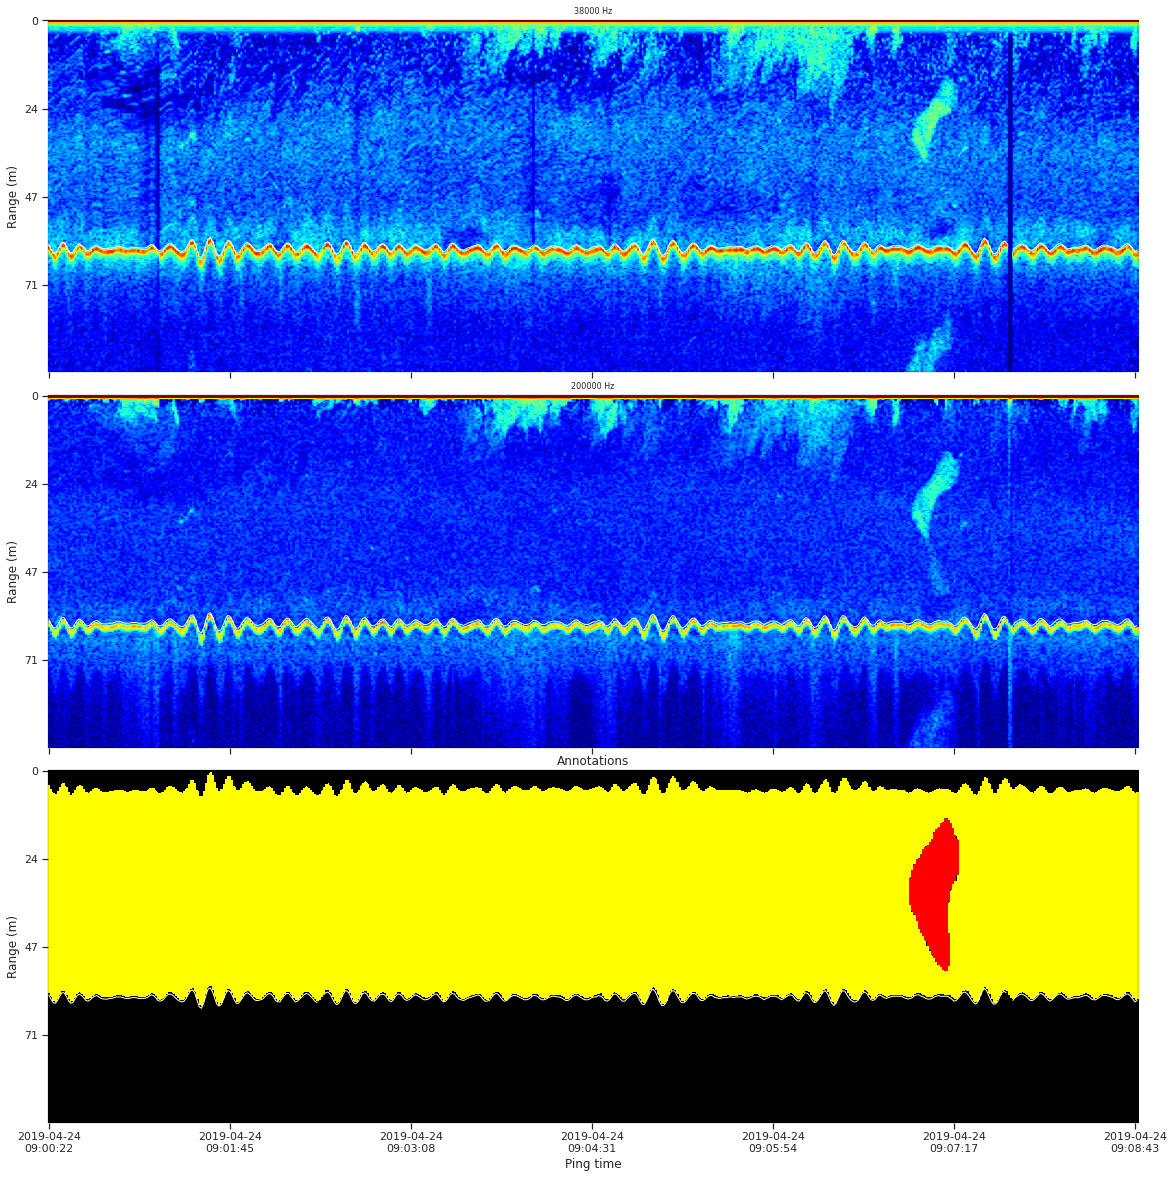

In [580]:
survey.visualize(ping_idx=50152, n_pings=500, range_idx=0, 
                 n_range=500, draw_seabed=True, show_labels=True, frequencies=[38000,200000])

In [544]:
survey.ds.transducer_draft.mean(dim='frequency').values

array([5. , 5. , 5. , ..., 7.5, 7.5, 7.5])

In [546]:
survey.ds.dims['ping_time']

3984739

In [441]:
survey.ds.sv.sel(frequency=frequencies).isel(ping_time=png_tm, range=slice_range).dropna(dim='range')

<xarray.DataArray 'sv' (frequency: 6, ping_time: 256, range: 632)>
dask.array<getitem, shape=(6, 256, 632), dtype=float32, chunksize=(1, 256, 632), chunktype=numpy.ndarray>
Coordinates:
    channel_id  (frequency) <U38 dask.array<chunksize=(6,), meta=np.ndarray>
  * frequency   (frequency) float64 3.8e+04 1.8e+04 7e+04 1.2e+05 2e+05 3.33e+05
    latitude    (ping_time) float64 dask.array<chunksize=(256,), meta=np.ndarray>
    longitude   (ping_time) float64 dask.array<chunksize=(256,), meta=np.ndarray>
  * ping_time   (ping_time) datetime64[ns] 2019-04-23T16:57:58.626000 ... 201...
  * range       (range) float64 379.7 379.9 380.1 380.3 ... 499.2 499.4 499.6
    raw_file    (ping_time) <U29 dask.array<chunksize=(256,), meta=np.ndarray>

In [557]:
samplers = [
    'BackgroundZarr(echograms_train, self.window_size)',
    'SeabedZarr(echograms_train, self.window_size)',
    'SchoolZarr(echograms_train, self.window_size, 27)',
    'SchoolZarr(echograms_train,  self.window_size, 1)',
    'SchoolSeabedZarr(echograms_train, self.window_size, max_dist_to_seabed=self.window_size[0]//2, fish_type=27)',
    'SchoolSeabedZarr(echograms_train, self.window_size, max_dist_to_seabed=self.window_size[0]//2, fish_type=1)'
]

In [558]:
sampler_probs = [1, 5, 5, 5, 5, 5]
sampler_probs = np.array(sampler_probs)
sampler_probs = np.cumsum(sampler_probs).astype(float)
sampler_probs /= np.max(sampler_probs)
sampler_probs

array([0.03846154, 0.23076923, 0.42307692, 0.61538462, 0.80769231,
       1.        ])

In [573]:
i = np.random.rand()
i

0.26251777126596465

In [564]:
samplers[0]

'BackgroundZarr(echograms_train, self.window_size)'

In [574]:
samplers[np.where(i < sampler_probs)[0][0]]

'SchoolZarr(echograms_train, self.window_size, 27)'

In [554]:
from batch.samplers.background import BackgroundZarr

In [566]:
BackgroundZarr(survey, [256, 256])

In [572]:
np.where(i < sampler_probs)[0][0]

3

In [601]:
from pipeline_train_predict.pipeline import DataZarr

ERROR! Session/line number was not unique in database. History logging moved to new session 13


In [628]:
from paths import load_yaml_config, pipeline_config
aa = pipeline_config()


In [629]:
aa

{'data_mode': 'zarr',
 'frequencies': [18, 38, 120, 200],
 'dev': 1,
 'num_workers': 20,
 'window_dim': 256,
 'batch_size': 16,
 'lr': 0.005,
 'lr_reduction': 0.5,
 'momentum': 0.95,
 'test_iter': 20,
 'log_step': 1000,
 'lr_step': 1000,
 'iterations': 2000,
 'partition': 'selected surveys',
 'train_surveys': ['S2019847'],
 'val_surveys': ['S2019847'],
 'save_model_params': False,
 'eval_mode': 'all',
 'model_names': [],
 'partition_predict': 'all surveys',
 'selected_surveys': ['S2019847'],
 'colors_list': ['blue'],
 'save_labels': False,
 'labels_available': False,
 'resume_writing': False}

In [624]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
aa = objectview(aa)

ERROR! Session/line number was not unique in database. History logging moved to new session 29


In [627]:
print(aa)

In [ ]:
DataZarr(aa)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-626-40f029195c39>", line 1, in <module>
    DataZarr(aa)
  File "/home/a39083/UNET-Sampling/crimac_unet/pipeline_train_predict/pipeline.py", line 1146, in __init__
    mode=opt.data_mode)
  File "/home/a39083/UNET-Sampling/crimac_unet/data/echogram.py", line 1075, in get_data_readers
    return get_zarr_files(years, frequencies, minimum_shape)
  File "/home/a39083/UNET-Sampling/crimac_unet/data/echogram.py", line 1017, in get_zarr_files
    assert len(zarr_files) > 0, f"No survey data found at {path_to_zarr_files}"
AssertionError: No survey data found at /mnt/c/DATAscratch/crimac-scratch/2019/S2019847_0511/ACOUSTIC/GRIDDED/

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages

In [11]:
# Example Echogram and Annotations
x, y = 50952, 148
survey = readers[0]
a_survey = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=True, frequencies=[18000, 38000, 70000, 200000])
a_label = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)

modified = P_refine_label_boundary(ignore_zero_inside_bbox=False,threshold_val=[1e-07, 1e-04],
                                )(data = a_survey, labels = a_label, echogram = a_survey)

Original Labels: (array([-1.,  0., 27.], dtype=float32), array([58667,  1404,  5465]))
Modified Labels: (array([-1.,  0., 27.], dtype=float32), array([ 5878, 55177,  4481]))


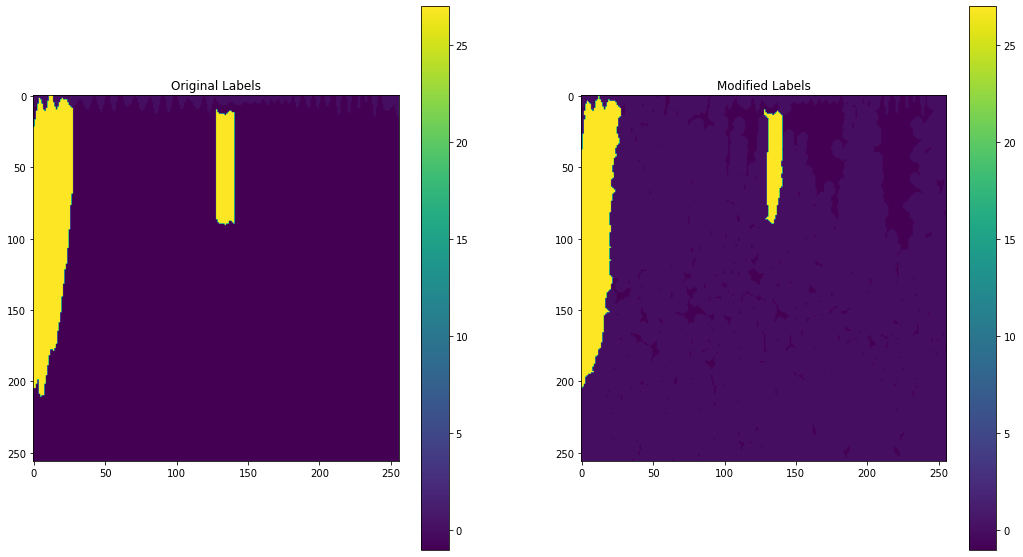

In [12]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.title('Original Labels')
plt.imshow(a_label.T)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Modified Labels')
plt.imshow(modified[1].T)
plt.colorbar()


print('Original Labels:',  np.unique(a_label, return_counts=True))
print('Modified Labels:',  np.unique(modified[1], return_counts=True))

# It removes the information from 3 pixels of each edge !!!

# dB Domain - Analyzing the Near Surface Area (Height)

# Near Field Calculation

In [14]:
# Calculation of how many pixels will be removed

tw = 37.5 # Transducer width of ES38B = 37.5 cm
wl = 3.95 # Wavelength of sound at 38 kHz in seawater = 3.95 cm
range_rate = 0.189

Rb = (tw**2)/wl # in cm
pRb = Rb/(100*range_rate)


print('Near Field = '+str("{:.2f}".format(Rb/100))+' m'+' which is equal to '+str("{:.2f}".format(pRb))+' pixels')


Near Field = 3.56 m which is equal to 18.84 pixels


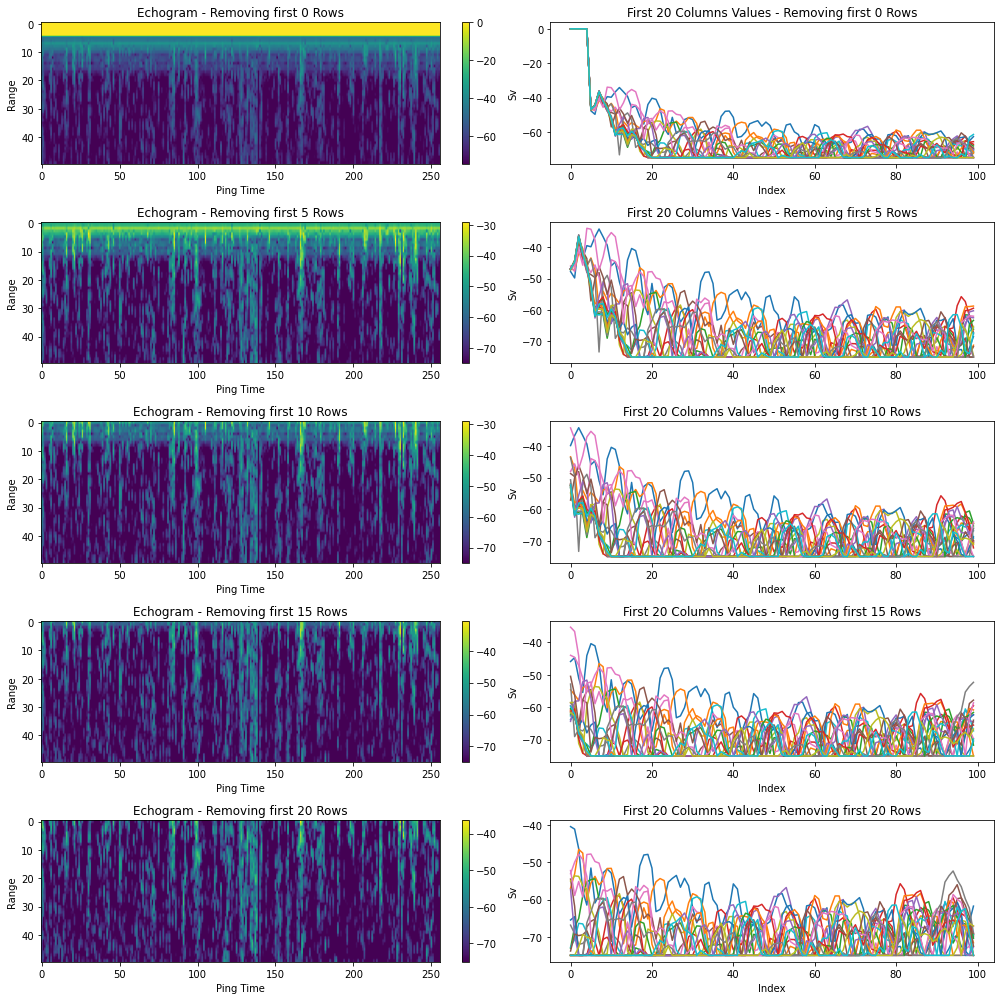

In [15]:
survey = readers[0]
remove_near_surface = [0, 5, 10, 15, 20] # Number of pixels removed vertically from sea surface
plt.figure(figsize = (14,14))
for i in range(len(remove_near_surface)):
    x, y = 46976, 128+remove_near_surface[i] 
    deneme = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=False, frequencies=[38000])
    aa = db_with_limits(deneme[0].values).astype('float64')
    
    # Subplot for echogram
    plt.subplot(len(remove_near_surface),2,2*i+1)
    plt.title('Echogram - Removing first '+str(remove_near_surface[i])+' Rows')
    plt.imshow(aa.T[0:50], aspect="auto")
    plt.colorbar(fraction=0.05)
    plt.xlabel('Ping Time')
    plt.ylabel('Range')
    
    # Subplot for the Sv Values
    plt.subplot(len(remove_near_surface),2,2*i+2)
    plt.title('First '+str(20)+ ' Columns Values - Removing first '+ str(remove_near_surface[i]) + ' Rows')
    for i in range(20):
        plt.plot(aa.T[0:100,i])
    plt.xlabel('Index')
    plt.ylabel('Sv')

    plt.tight_layout()
    #plt.savefig('near_surface')
    
    

# The Closest Sandeel Pixel to the Sea Surface

In [93]:
# All Acoustic Prediction
dd = '/data/2019/S2019847/ACOUSTIC/GRIDDED/S2019847'

sv_fname = dd+'_sv.zarr'
annotations_fname = dd+'_labels.zarr'
schools_fname = dd+'_labels.parquet.csv'
bottom_fname = dd+'_bottom.zarr'

# Open the files
zarr_grid = xr.open_zarr(sv_fname)
zarr_pred = xr.open_zarr(annotations_fname, consolidated = True)
zarr_bottom = xr.open_zarr(bottom_fname)
df = pd.read_csv(schools_fname, header=0)

In [17]:
# Summary School Information
nsan, noth, npos = len(df[df['category']==27]), len(df[df['category']==1]), len(df[df['category']==6009])
print('Number of Sandeel Schools = ', nsan, 'Number of Other Schools = ', noth,
      'Number of Sandeel Schools = ', npos)

Number of Sandeel Schools =  2786 Number of Other Schools =  4741 Number of Sandeel Schools =  477


In [18]:
df[df['category']==27].sort_values(by = 'upperdept').head(10) # Sorting Fish School data basedon upperdepth

ID  object         type  category  proportion  \
5546  5547__School-6085    5547  School-6085      27.0           1   
5550  5551__School-6086    5551  School-6086      27.0           1   
43        44__School-41      44    School-41      27.0           1   
616     617__School-620     617   School-620      27.0           1   
45        46__School-44      46    School-44      27.0           1   
608     609__School-615     609   School-615      27.0           1   
602     603__School-609     603   School-609      27.0           1   
4553  4554__School-5002    4554  School-5002      27.0           1   
4858  4859__School-5325    4859  School-5325      27.0           1   
88        89__School-84      89    School-84      27.0           1   

                       startping                     endping  startpingindex  \
5546  2019-05-09 05:08:29.282000  2019-05-09 05:08:32.798000         3099780   
5550  2019-05-09 05:20:48.220000  2019-05-09 05:20:51.376000         3101880   
43    2019-04-24 09:13:45.579000  2019-04-24 09:13:57.595000           50952   
616   2019-04-26 09:33:10.438000  2019-04-26 09:33:21.001000          398384   
45    2019-04-24 09:25:59.829000  2019-04-24 09:26:24.860000           51605   
608   2019-04-26 09:31:00.266000  2019-04-26 09:31:03.079000          398014   
602   2019-04-26 09:06:14.298000  2019-04-26 09:06:22.048000          393790   
4553  2019-05-06 05:58:06.657000  2019-05-06 05:58:20.720000         2389971   
4858  2019-05-07 08:42:16.407000  2019-05-07 08:42:25.985000         2659779   
88    2019-04-24 12:13:42.579000  2019-04-24 12:13:47.391000           62839   

      endpingindex  upperdept  lowerdept  upperdeptindex  lowerdeptindex  
5546       3099790  10.108007   9.918057               6              34  
5550       3101889  10.203556   9.823652               6              36  
43           50964  11.196256  25.842813              30             111  
616         398414  12.253737  16.784914              23              85  
45           51627  12.841512  25.706467              29             184  
608         398022  12.877315  19.893232              27              92  
602         393812  13.203077  19.528427              29             148  
4553       2390011  14.182439  14.372391              23             210  
4858       2659806  14.635820  15.585581              38             137  
88           62845  15.014408  28.778046              58             135

# Bottom Index Analysis

In [19]:
# Number of Pings without seabed
bottom_indices = (2634 - zarr_bottom.bottom_range.sum(dim='range'))
n_nobottom = len(bottom_indices.where(bottom_indices==2634, drop=True))
print('Number of Pings without bottom info = '+str(n_nobottom)+
      ' ('+str("{:.2f}".format(100*n_nobottom/len(zarr_bottom.ping_time)))+'%)')

Number of Pings without bottom info = 153869 (3.86%)


In [20]:
# By removing first 20 rows, the number of pings having the seabed on 532nd index or less
n_covered = len(bottom_indices.where(((bottom_indices<=532) & (bottom_indices!=0)), drop=True))
print('Number of Pings having seabed at 532nd index or less (Excluding Nans) = '+str(n_covered)+
      ' ('+str("{:.2f}".format(100*n_covered/len(zarr_bottom.ping_time)))+'% of the echogram)')

Number of Pings having seabed at 532nd index or less (Excluding Nans) = 3651068 (91.63% of the echogram)


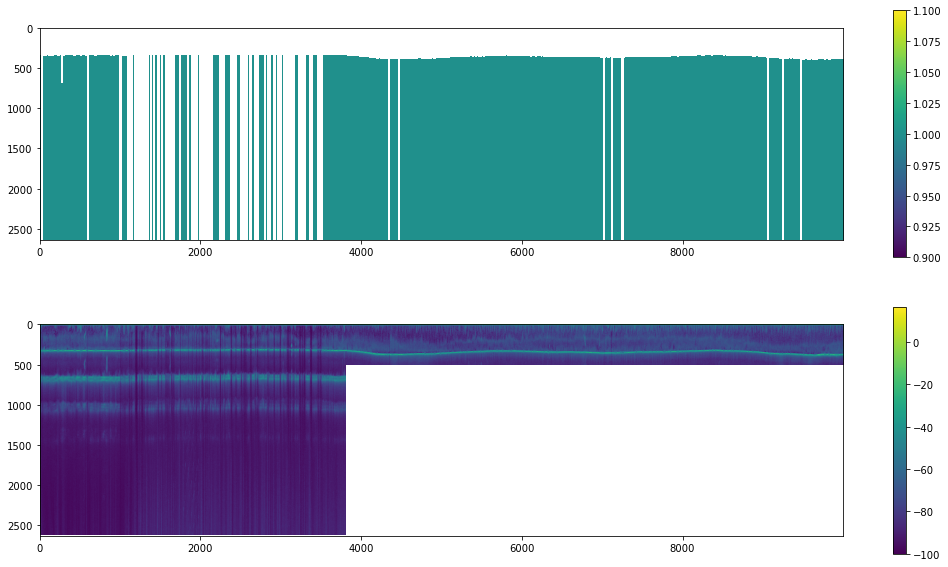

In [21]:
# Example Bottom Illustration with Problematic Fields
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.imshow(zarr_bottom.bottom_range[50000:60000,:].T.values)
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(db(zarr_grid.sv[0,50000:60000,:].T.values))
plt.colorbar()
plt.show()

# Nils Olav'a Sorulacak - Upped Depth Index and Upper Dept Contradiction

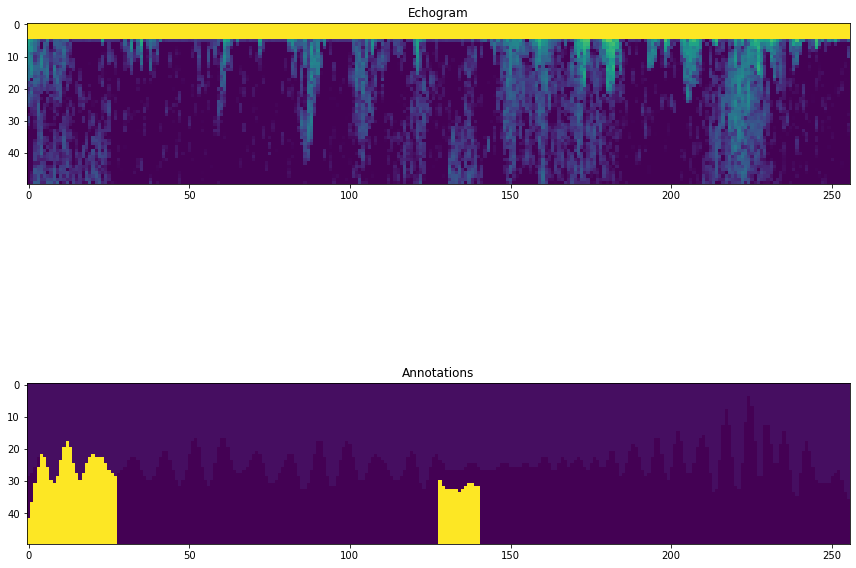

In [22]:
# Upped Depth Index and Upper Dept Contradiction - Nils Olav'a Sorulacak

# !! Only the fish schools at index 3099780, and 3101880 have pixels above 20 threshold

x, y = 50952, 128 

a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=False, frequencies=[200000]))
c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)

thr = 0
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.title('Echogram')
plt.imshow(a[0,:,:].values.T[thr:50,:])
#plt.colorbar()
plt.subplot(2,1,2)
plt.title('Annotations')
plt.imshow(c.T[thr:50,:])
plt.tight_layout()
#plt.colorbar()

plt.show()


# Example Ilustrations before Extracting the Patch Information

mean background Sv = -71.70924  median background Sv = -75.0
mean Sandeel Sv = -63.975594  median Sandeel Sv = -66.2623


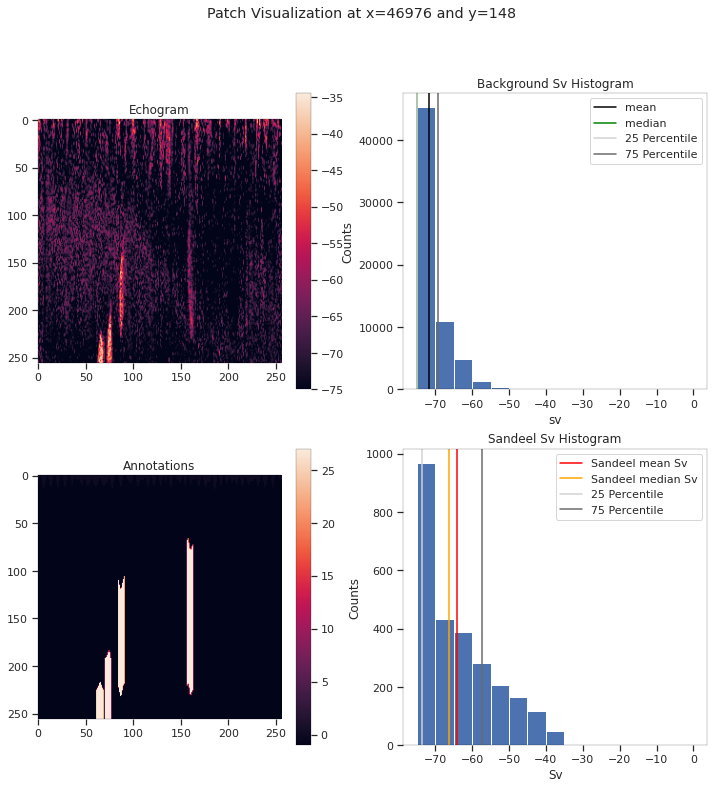

In [213]:
examp_illustr(survey, x=46976, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Creating Coordinates and Metadata Structure

In [24]:
survey = readers[0]

exc_pix_vert = 20 # Vertically excluded pixels

n_pings, n_range = survey.shape

xs = np.arange(patch_size[0] // 2, n_pings - patch_size[0] // 2, patch_size[0])
ys = np.arange(exc_pix_vert + patch_size[1] // 2, patch_size[1] * 3 - patch_size[1] // 2, patch_size[1])

(xs, ys) = np.meshgrid(xs, ys)
coordinate_list = np.array([xs.ravel(), ys.ravel()]).T[:-2,:] # Last two rows excluded

fish_categories = list(survey.fish_categories)


# (Modified) Producing Metadata for Each Patch Through the Survey Data

In [25]:
# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(coordinate_list), 53))  ## UPDATE EDILECEK
quantiles = [0, 0.25, 0.5, 0.75, 0.95, 1]

for i, (x, y) in tqdm(enumerate(coordinate_list), total=len(coordinate_list)):
    # Data Loading & Preparations
    org_sv = survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                   idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                   return_numpy=False, frequencies=[38000, 200000])
    data_Sv = xr_db_with_limits(org_sv)
    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                         idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                         return_numpy=False)
    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]
    y_label = survey.get_label_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                     idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                     return_numpy=True)
    modified = P_refine_label_boundary(ignore_zero_inside_bbox=False,
                                       threshold_val=[1e-07, 1e-04], frequencies=[38, 200])(data=org_sv.values,
                                                                                            labels=y_label,
                                                                                            echogram=org_sv.values)
    modified = modified[1]  # Final 2D modified annotations
    np_Sv = data_Sv.sel(frequency=38000).values  # Sv data slice in 38 kHz frequency

    # Coordinates
    data[i, 0] = x
    data[i, 1] = y

    # Patch Statistics
    data[i, 2] = mean_Sv = np.nanmean(np_Sv)  # mean (excluding nan)
    data[i, 3] = mode_Sv = st.mode(np_Sv.flatten())[0]  # mode (excluding nan)
    data[i, 4] = np.nanstd(np_Sv)  # standard deviation (excluding nan)
    data[i, 5], data[i, 6], data[i, 7], data[i, 8], data[i, 9], data[i, 10] = np.nanquantile(np_Sv, q=quantiles)

    # Number of Pixels
    data[i, 11] = seabed_mask.sum().values  # Pixels below seabed
    data[i, 12] = len(modified[modified == 1])  # Other class
    data[i, 13] = len(modified[modified == 27])  # Sandeel class
    data[i, 14] = len(modified[modified == 6009])  # Possible Sandeel class
    data[i, 15] = np.isnan(np_Sv).sum()  # Number of nan pixels
    data[i, 16] = 256 * 256 - (
                data[i, 12] + data[i, 13] + data[i, 14] + data[i, 15])  # Background class (Excluding nan values)

    # Class Statistics

    # Other Class
    if data[i, 12] != 0:
        ot_filt = np_Sv[modified == 1]
        # Mean, Mode, Std Other Sv
        data[i, 17], data[i, 18], data[i, 19] = ot_filt.mean(), st.mode(ot_filt.flatten())[0], np.std(ot_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 20], data[i, 21], data[i, 22], data[i, 23], data[i, 24], data[i, 25] = np.quantile(ot_filt, q=quantiles)

    # Sandeel Class
    if data[i, 13] != 0:
        sd_filt = np_Sv[modified == 27]
        # Mean, Mode, Std Sandeel Sv
        data[i, 26], data[i, 27], data[i, 28] = sd_filt.mean(), st.mode(sd_filt.flatten())[0], np.std(sd_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 29], data[i, 30], data[i, 31], data[i, 32], data[i, 33], data[i, 34] = np.quantile(sd_filt, q=quantiles)

    # Possible Sandeel Class
    if data[i, 14] != 0:
        ps_filt = np_Sv[modified == 6009]
        # Mean, Mode, Std possible Sandeel Sv
        data[i, 35], data[i, 36], data[i, 37] = ps_filt.mean(), st.mode(ps_filt.flatten())[0], np.std(ps_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 38], data[i, 39], data[i, 40], data[i, 41], data[i, 42], data[i, 43] = np.quantile(sd_filt, q=quantiles)

    # Background
    if data[i, 16] == 256 * 256:
        # If there is no fish, statistics are the same as patch
        data[i, 44], data[i, 45], data[i, 46] = data[i, 2], data[i, 3], data[i, 4]
        data[i, 47], data[i, 48], data[i, 49], data[i, 50], data[i, 51], data[i, 52] = data[i, 20], data[i, 21], data[
            i, 22], data[i, 23], data[i, 24], data[i, 25]
    else:
        bg_flt = np_Sv[np.logical_or((modified == 0), (modified == -1))]
        # Mean, Mode, Std Background Sv
        data[i, 44], data[i, 45], data[i, 46] = np.nanmean(bg_flt), st.mode(bg_flt.flatten(), nan_policy='omit')[
            0], np.nanstd(bg_flt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 47], data[i, 48], data[i, 49], data[i, 50], data[i, 51], data[i, 52] = np.nanquantile(bg_flt,
                                                                                                      q=quantiles)

 48%|████▊     | 14838/31128 [4:56:54<5:43:18,  1.26s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 22977/31128 [7:40:47<2:41:58,  1.19s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████▉| 30940/31128 [10:20:41<03:57,  1.26s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`-

# (Without Modification) Producing Metadata for Each Patch Through the Survey Data

In [11]:

# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(coordinate_list), 2 + 3 + len(survey.fish_categories) + 15))  ## UPDATE EDILECEK

for i, (x, y) in tqdm(enumerate(coordinate_list), total=len(coordinate_list)):
    data[i, 0] = x
    data[i, 1] = y

    data_Sv = xr_db_with_limits(survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                                      idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                      return_numpy=False,
                                                      frequencies=[38000]))  # Calculating Sv with limits
    mean_Sv = data_Sv.mean().values
    median_Sv = data_Sv.median(dim=['ping_time', 'range']).values

    data[i, 2] = mean_Sv  # Mean Sv value
    data[i, 3] = median_Sv  # Median Sv value

    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                          idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                          return_numpy=False)
    n_pixels_below_seabed = seabed_mask.sum().values
    data[i, 4] = n_pixels_below_seabed  # Pixels under seabed

    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]

    # Number of Pixels
    data[i, 5] = labels.sel(category=1).sum().values  # Other class
    data[i, 6] = labels.sel(category=27).sum().values  # Sandeel class
    data[i, 7] = labels.sel(category=6009).sum().values  # Possible Sandeel class
    data[i, 8] = 256 * 256 - (data_Sv * data_Sv.isnull()).count().values  # Number of nan pixels
    data[i, 9] = 256 * 256 - (
                data[i, 5] + data[i, 6] + data[i, 7] + data[i, 8])  # Background class (Excluding nan values)

    # Average Intensity Values
    if data[i, 5] != 0: 
        data[i, 10] = ((data_Sv * labels.sel(category=1)).sum() / data[i, 5]).values  # Average Other Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Ot = data_Sv[0].values[labels.sel(category=1) == 1]
        data[i, 14], data[i, 15], data[i, 16] = np.nanstd(sd_Ot), np.percentile(sd_Ot, 25), np.percentile(sd_Ot, 75)
        
    if data[i, 6] != 0: 
        data[i, 11] = ((data_Sv * labels.sel(category=27)).sum() / data[i, 6]).values  # Average Sandeel Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Sd = data_Sv[0].values[labels.sel(category=27) == 1]
        data[i, 17], data[i, 18], data[i, 19] = np.nanstd(sd_Sd), np.nanpercentile(sd_Sd, 25), np.nanpercentile(sd_Sd, 75)
        
    if data[i, 7] != 0: data[i, 12] = (
        (data_Sv * labels.sel(category=6009)).sum() / data[i, 7]).values  # Average Possible Sandeel Sv
    if data[i, 9] == 256 * 256:
        data[i, 13] = mean_Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Bg = data_Sv[0].values
        data[i, 20], data[i, 21], data[i, 22] = np.nanstd(sd_Bg), np.nanpercentile(sd_Bg, 25), np.nanpercentile(sd_Bg, 75)
    else:
        sd_Bg = data_Sv[0].values[np.logical_and(labels.sel(category=27).values != 1,
                                                 labels.sel(category=1).values != 1,
                                                 labels.sel(category=6009).values != 1)]
        data[i, 13] = np.nansum(sd_Bg) / data[i, 9]  # Average Background Sv - Excluding nan values
        # Assigning std, 25 percentile and 75 percentile
        data[i, 20], data[i, 21], data[i, 22] = np.nanstd(sd_Bg), np.nanpercentile(sd_Bg, 25), np.nanpercentile(sd_Bg, 75)


 27%|██▋       | 8287/31128 [5:43:14<13:17:16,  2.09s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 16233/31128 [11:07:22<13:48:08,  3.34s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 78%|███████▊  | 24320/31128 [18:39:44<6:10:21,  3.26s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

# Saving & Loading the Data

In [7]:
#data[:,16] = 256 * 256 - (data[:, 12] + data[:, 13] + data[:, 14] + data[:, 15]) # nop_bg correction
#np.savetxt("Sv_modified_patch_data.csv", data, delimiter=",")
Sv_data = np.loadtxt('Sv_modified_patch_data.csv', delimiter=",")

pdata = pd.DataFrame(Sv_data)
names_org = ['x', 'y', 'mean_Sv', 'median_Sv', 
         'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan',
         'nop_background', 'mean_other', 'mean_sandeel', 'mean_possandeel', 'mean_background',
         'std_other', '25_other', '75_other',
         'std_sandeel', '25_sandeel', '75_sandeel',
        'std_background', '25_background', '75_background']
names_modified = ['x', 'y', 'mean_Sv', 'mode_Sv', 'std_Sv', 
                  '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv',
                  'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan','nop_background',
                  'mean_other', 'mode_other', 'std_other',
                  '0_Other', '25_Other', '50_Other', '75_Other', '95_Other', '100_Other',
                  'mean_sandeel', 'mode_sandeel', 'std_sandeel',
                  '0_sandeel', '25_sandeel', '50_sandeel', '75_sandeel', '95_sandeel', '100_sandeel',
                  'mean_psandeel', 'mode_psandeel', 'std_psandeel',
                  '0_psandeel', '25_psandeel', '50_psandeel', '75_psandeel', '95_psandeel', '100_psandeel',
                  'mean_bg', 'mode_bg', 'std_bg',
                  '0_bg', '25_bg', '50_bg', '75_bg', '95_bg', '100_bg']
pdata.columns = names_modified
pdata[pdata['nop_sandeel']>=0].head()
#pdata.info()

x      y    mean_Sv  mode_Sv    std_Sv  0_Sv  25_Sv  50_Sv      75_Sv  \
0   128.0  148.0 -73.024147    -75.0  3.740309 -75.0  -75.0  -75.0 -72.643904   
1   384.0  148.0 -72.961578    -75.0  3.817220 -75.0  -75.0  -75.0 -72.542253   
2   640.0  148.0 -73.257332    -75.0  3.570127 -75.0  -75.0  -75.0 -73.920282   
3   896.0  148.0 -74.101067    -75.0  2.439322 -75.0  -75.0  -75.0 -75.000000   
4  1152.0  148.0 -74.086021    -75.0  2.553980 -75.0  -75.0  -75.0 -75.000000   

       95_Sv  ...  100_psandeel    mean_bg  mode_bg    std_bg  0_bg  25_bg  \
0 -64.266907  ...           0.0 -73.024147    -75.0  3.740309 -75.0  -75.0   
1 -63.983732  ...           0.0 -72.961578    -75.0  3.817220 -75.0  -75.0   
2 -64.613506  ...           0.0 -73.257332    -75.0  3.570127 -75.0  -75.0   
3 -68.072987  ...           0.0 -74.101067    -75.0  2.439322 -75.0  -75.0   
4 -67.934610  ...           0.0 -74.086021    -75.0  2.553980 -75.0  -75.0   

   50_bg      75_bg      95_bg     100_bg  
0  -75.0 -72.643904 -64.266907 -50.807701  
1  -75.0 -72.542253 -63.983732 -53.094238  
2  -75.0 -73.920282 -64.613506 -50.615807  
3  -75.0 -75.000000 -68.072987 -47.039703  
4  -75.0 -75.000000 -67.934610 -54.773499  

[5 rows x 53 columns]

# Summary Patch Information

In [8]:
sb = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Sandeel + Background
so = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Sandeel + Other
sp = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel
spo = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel + Other

ob = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Other + Background
op = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Other + Possandeel
pb = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Possandeel + Background

b = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Possandeel + Background

info = np.array([sb, so, sp, spo, ob, op, pb, b], ndmin = 2)
names = np.array(['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
                      'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg'], ndmin = 2)
info, names

(array([[ 1340,   519,    31,    96,  1827,   164,   102, 27049]]),
 array([['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
         'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg']], dtype='<U17'))

# Histogram Plots

# Mean Background and Fish School Sv Distributions

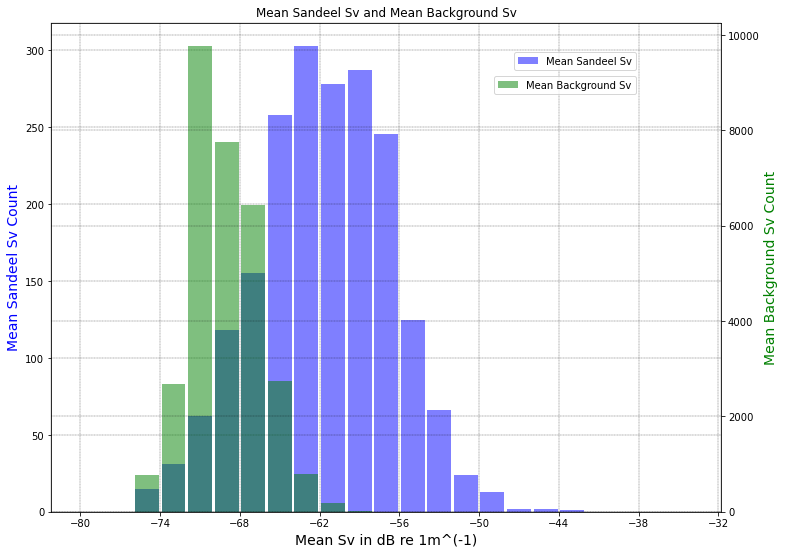

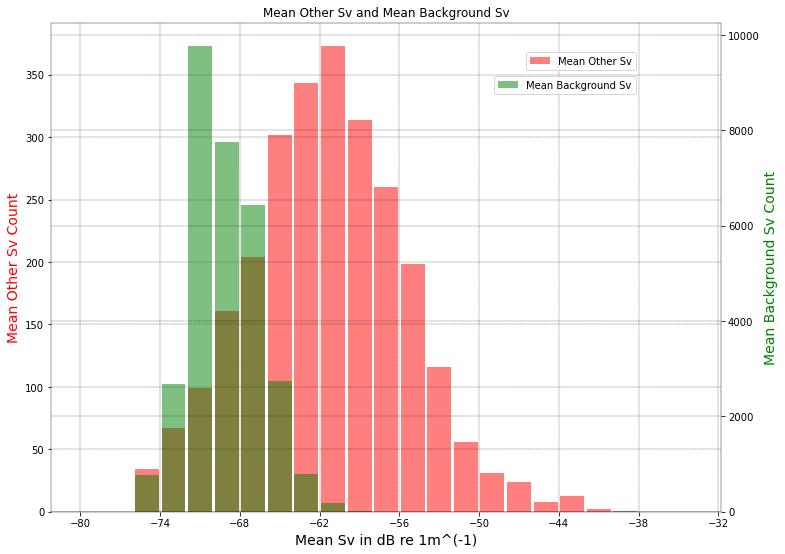

In [14]:
# Mean Values Plot
hist_2_axis(pdata, 'mean_sandeel', 'mean_bg', fig_finish = -32, s_bin = 2,
            y1label = 'Mean Sandeel Sv', y2label = 'Mean Background Sv', 
            xlabel="Mean Sv in dB re 1m^(-1)", condi = 'nop_sandeel')
hist_2_axis(pdata, 'mean_other', 'mean_bg', fig_finish = -32, s_bin = 2,
            y1label = 'Mean Other Sv', y2label = 'Mean Background Sv', 
            xlabel="Mean Sv in dB re 1m^(-1)", condi = 'nop_other', col1='red')

In [15]:
# High Background Pixels (Zooplanktons here - nop_below_seabed<0 and close to the surface)
pdata[pdata['nop_below_seabed']==0].sort_values(by='mean_bg', ascending=False)

x      y    mean_Sv  mode_Sv    std_Sv  0_Sv      25_Sv  \
15385  3938688.0  148.0 -59.747452    -75.0  6.740470 -75.0 -63.431708   
15404  3943552.0  148.0 -59.758457    -75.0  7.609642 -75.0 -64.031872   
15384  3938432.0  148.0 -59.899563    -75.0  7.480749 -75.0 -63.933967   
15464  3958912.0  148.0 -60.360703    -75.0  8.169872 -75.0 -65.876881   
15455  3956608.0  148.0 -60.477116    -75.0  8.232512 -75.0 -65.910591   
...          ...    ...        ...      ...       ...   ...        ...   
23530  2039168.0  404.0 -75.000000    -75.0  0.000000 -75.0 -75.000000   
23531  2039424.0  404.0 -75.000000    -75.0  0.000000 -75.0 -75.000000   
23532  2039680.0  404.0 -75.000000    -75.0  0.000065 -75.0 -75.000000   
23533  2039936.0  404.0 -75.000000    -75.0  0.000000 -75.0 -75.000000   
23575  2050688.0  404.0 -75.000000    -75.0  0.000000 -75.0 -75.000000   

           50_Sv      75_Sv      95_Sv  ...  100_psandeel    mean_bg  mode_bg  \
15385 -58.577766 -54.886183 -50.596138  ...           0.0 -59.747452    -75.0   
15404 -58.255678 -54.168175 -49.494267  ...           0.0 -59.758457    -75.0   
15384 -58.225817 -54.345251 -50.205686  ...           0.0 -59.899563    -75.0   
15464 -58.900606 -53.968508 -49.112076  ...           0.0 -60.360703    -75.0   
15455 -58.911030 -54.074288 -49.214949  ...           0.0 -60.477116    -75.0   
...          ...        ...        ...  ...           ...        ...      ...   
23530 -75.000000 -75.000000 -75.000000  ...           0.0 -75.000000    -75.0   
23531 -75.000000 -75.000000 -75.000000  ...           0.0 -75.000000    -75.0   
23532 -75.000000 -75.000000 -75.000000  ...           0.0 -75.000000    -75.0   
23533 -75.000000 -75.000000 -75.000000  ...           0.0 -75.000000    -75.0   
23575 -75.000000 -75.000000 -75.000000  ...           0.0 -75.000000    -75.0   

         std_bg  0_bg      25_bg      50_bg      75_bg      95_bg     100_bg  
15385  6.740470 -75.0 -63.431708 -58.577766 -54.886183 -50.596138 -30.923607  
15404  7.609642 -75.0 -64.031872 -58.255678 -54.168175 -49.494267 -36.953403  
15384  7.480749 -75.0 -63.933967 -58.225817 -54.345251 -50.205686 -28.805616  
15464  8.169872 -75.0 -65.876881 -58.900606 -53.968508 -49.112076 -41.175560  
15455  8.232512 -75.0 -65.910591 -58.911030 -54.074288 -49.214949 -36.336590  
...         ...   ...        ...        ...        ...        ...        ...  
23530  0.000000 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -75.000000  
23531  0.000000 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -75.000000  
23532  0.000065 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -74.983589  
23533  0.000000 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -75.000000  
23575  0.000000 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -75.000000  

[10766 rows x 53 columns]

mean background Sv = -59.758457  median background Sv = -58.255676


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice.


mean Sandeel Sv = nan  median Sandeel Sv = nan


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


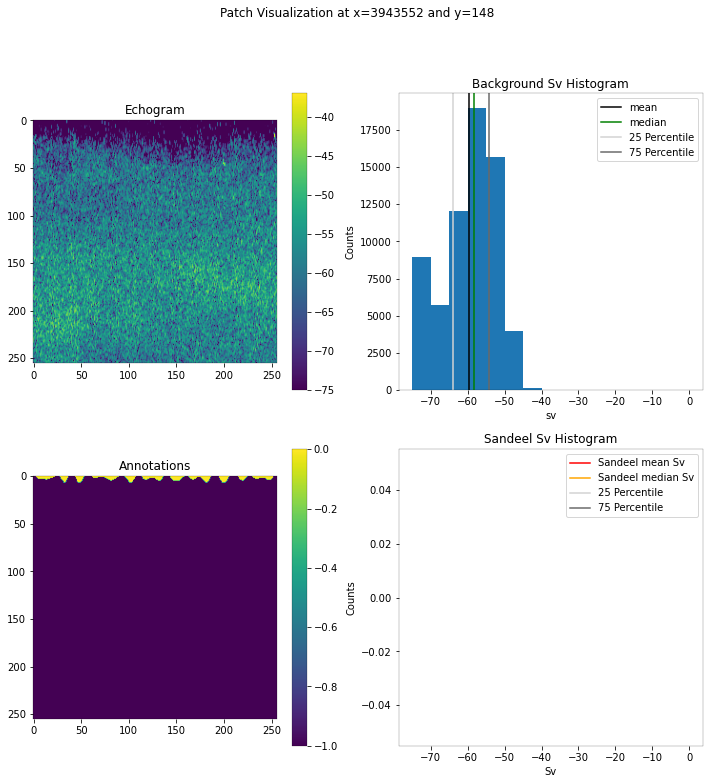

In [17]:
# High Background Sv without seabed
examp_illustr(survey, x=3943552, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Percentile Background and Fish School Sv Distributions

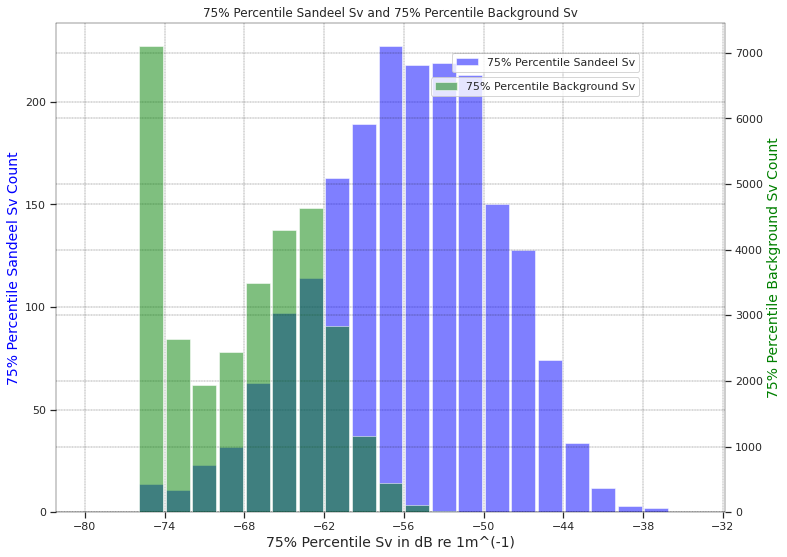

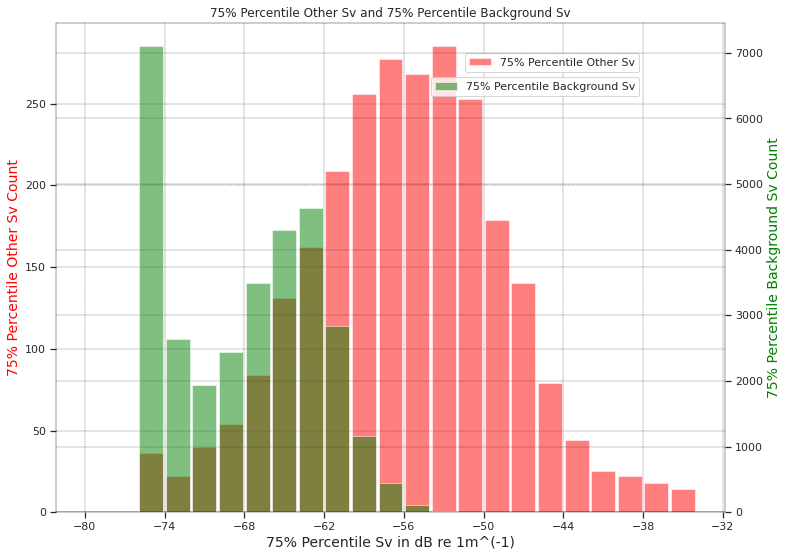

In [160]:
# Percentile Plots
hist_2_axis(pdata, '75_sandeel', '75_bg', fig_start = -80, fig_finish = -32, col1='blue',
            y1label = '75% Percentile Sandeel Sv', y2label = '75% Percentile Background Sv', 
            xlabel="75% Percentile Sv in dB re 1m^(-1)", condi = 'nop_sandeel')
hist_2_axis(pdata, '75_Other', '75_bg', fig_finish = -32, s_bin = 2, col1='red',
            y1label = '75% Percentile Other Sv', y2label = '75% Percentile Background Sv', 
            xlabel="75% Percentile Sv in dB re 1m^(-1)", condi = 'nop_other')


# Patches Containing Seabed Analysis

In [18]:
# Patches containing seabed filter - Not completely below the seabed
pdata[(pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']<256*256)].sort_values(by = 'mean_bg')

x      y    mean_Sv  mode_Sv     std_Sv  0_Sv      25_Sv  \
23514  2035072.0  404.0 -75.000000    -75.0   0.001313 -75.0 -75.000000   
23515  2035328.0  404.0 -74.999901    -75.0   0.013132 -75.0 -75.000000   
23511  2034304.0  404.0 -74.986870    -75.0   0.230618 -75.0 -75.000000   
23473  2024576.0  404.0 -74.967491    -75.0   0.603123 -75.0 -75.000000   
23469  2023552.0  404.0 -74.963120    -75.0   0.448744 -75.0 -75.000000   
...          ...    ...        ...      ...        ...   ...        ...   
30569  3841152.0  404.0 -59.919998    -75.0  11.156307 -75.0 -65.619673   
30552  3836800.0  404.0 -59.916035    -75.0  11.613592 -75.0 -66.412565   
8188   2096256.0  148.0 -59.913486    -75.0  10.586782 -75.0 -65.980011   
30568  3840896.0  404.0 -59.725693    -75.0  11.377179 -75.0 -65.955170   
30553  3837056.0  404.0 -59.274586    -75.0  11.517562 -75.0 -65.552053   

           50_Sv      75_Sv      95_Sv  ...  100_psandeel    mean_bg  mode_bg  \
23514 -75.000000 -75.000000 -75.000000  ...       0.00000 -75.000000    -75.0   
23515 -75.000000 -75.000000 -75.000000  ...       0.00000 -74.999901    -75.0   
23511 -75.000000 -75.000000 -75.000000  ...       0.00000 -74.986870    -75.0   
23473 -75.000000 -75.000000 -75.000000  ...       0.00000 -74.967491    -75.0   
23469 -75.000000 -75.000000 -75.000000  ...       0.00000 -74.963120    -75.0   
...          ...        ...        ...  ...           ...        ...      ...   
30569 -61.078241 -56.930561 -46.084463  ...       0.00000 -59.919998    -75.0   
30552 -60.415649 -55.987419 -46.373028  ...       0.00000 -59.916035    -75.0   
8188  -61.228664 -56.366182 -42.537056  ...       0.00000 -59.913486    -75.0   
30568 -60.361488 -55.969198 -46.200300  ...       0.00000 -59.733406    -75.0   
30553 -59.499540 -55.322298 -46.882681  ...     -53.01218 -59.278141    -75.0   

          std_bg  0_bg      25_bg      50_bg      75_bg      95_bg     100_bg  
23514   0.001313 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -74.667717  
23515   0.013132 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -72.656998  
23511   0.230618 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -65.305878  
23473   0.603123 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -40.940434  
23469   0.448744 -75.0 -75.000000 -75.000000 -75.000000 -75.000000 -56.013733  
...          ...   ...        ...        ...        ...        ...        ...  
30569  11.156307 -75.0 -65.619673 -61.078241 -56.930561 -46.084463   0.000000  
30552  11.613592 -75.0 -66.412565 -60.415649 -55.987419 -46.373028   0.000000  
8188   10.586782 -75.0 -65.980011 -61.228664 -56.366182 -42.537056  -0.612783  
30568  11.380982 -75.0 -65.960602 -60.369461 -55.976387 -46.275546   0.000000  
30553  11.519938 -75.0 -65.554092 -59.504704 -55.324760 -46.900427   0.000000  

[15982 rows x 53 columns]

# Patch and Background Distributions Containing Seabed

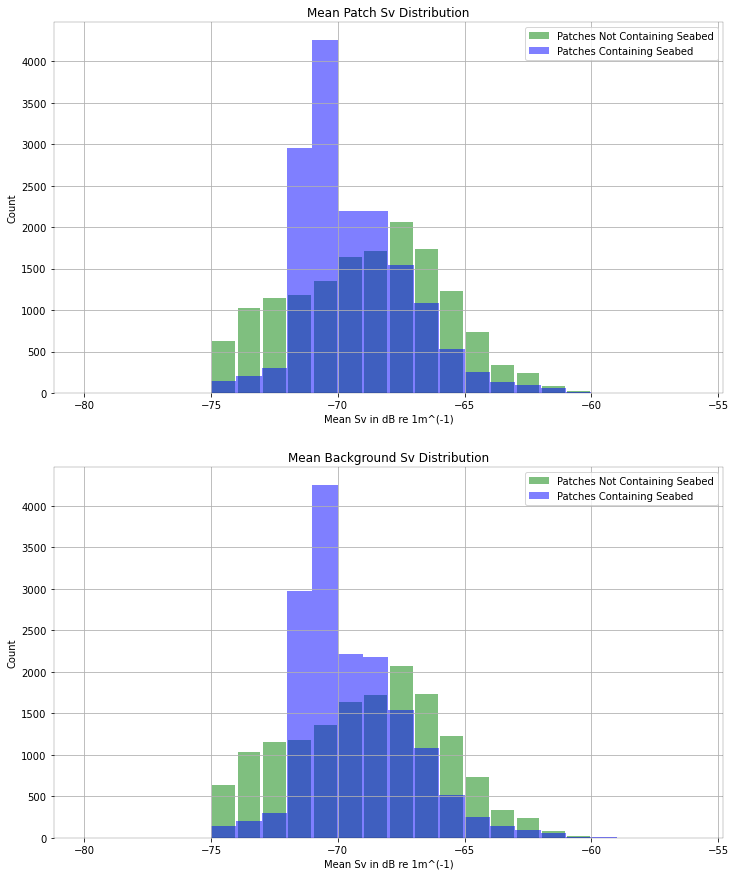

In [19]:

bins2 = np.arange(-80, -55, 1) # Bins and start finish binsize

bg_cont_seabed = pdata[(pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']<256*256)]
bg_nt_cont_seabed = pdata[(pdata['nop_below_seabed']==0) | (pdata['nop_below_seabed']==256*256)]

plt.figure(figsize=(12,15))
plt.subplot(2,1,1)
plt.title('Mean Patch Sv Distribution')
plt.hist(bg_nt_cont_seabed['mean_Sv'], color = 'green', bins = bins2, rwidth=0.9,alpha=0.5, label= 'Patches Not Containing Seabed')
plt.hist(bg_cont_seabed['mean_Sv'], 
         color = 'blue', bins = bins2, histtype='stepfilled',rwidth=0.7,alpha=0.5, label='Patches Containing Seabed')
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Mean Background Sv Distribution')
plt.hist(bg_nt_cont_seabed['mean_bg'], color = 'green', bins = bins2, rwidth=0.9,alpha=0.5, label='Patches Not Containing Seabed')
plt.hist(bg_cont_seabed['mean_bg'], 
         color = 'blue', bins = bins2, histtype='stepfilled',rwidth=0.7,alpha=0.5, label='Patches Containing Seabed')
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.grid()
plt.legend()

plt.show()

# Patches Containing Sandeel and Other

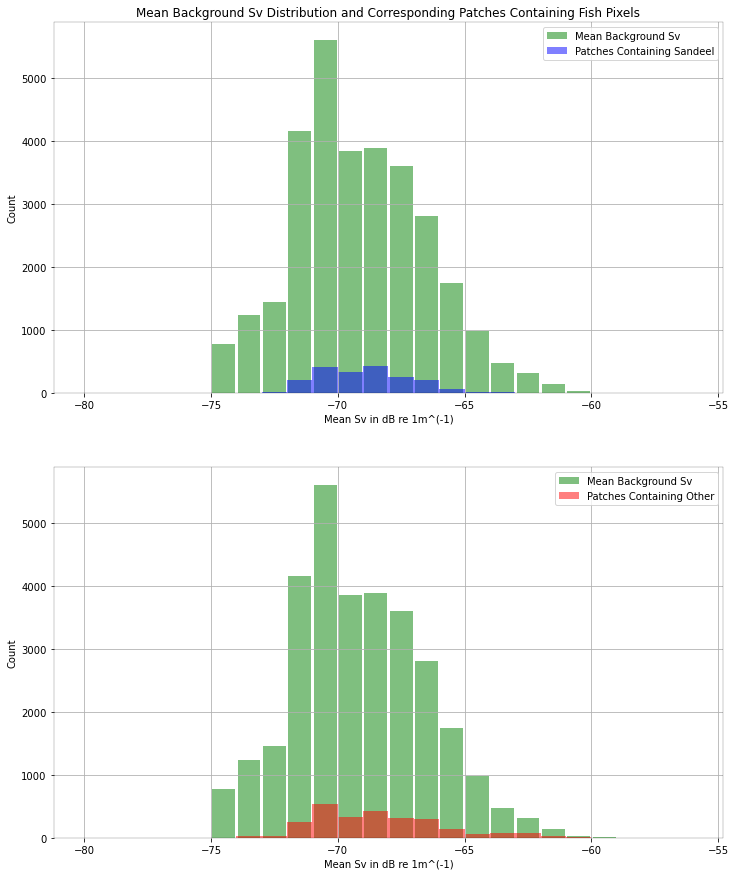

In [20]:

bins2 = np.arange(-80, -55, 1) # Bins and start finish binsize

plt.figure(figsize=(12,15))
plt.subplot(2,1,1)
plt.title('Mean Background Sv Distribution and Corresponding Patches Containing Fish Pixels')
plt.hist(pdata['mean_bg'], color = 'green', bins = bins2, alpha = 0.5, label='Mean Background Sv',
        rwidth=0.9)
plt.hist(pdata[pdata['nop_sandeel']>0]['mean_bg'], color = 'blue', 
         bins = bins2, histtype='stepfilled', alpha = 0.5, label='Patches Containing Sandeel', rwidth=0.9)
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.hist(pdata['mean_bg'], color = 'green', bins = bins2, alpha = 0.5, label='Mean Background Sv', rwidth=0.9)
plt.hist(pdata[pdata['nop_other']>0]['mean_bg'], 
         color = 'red', bins = bins2, 
         alpha = 0.5, histtype='stepfilled', label='Patches Containing Other', rwidth=0.9)
plt.grid()
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.legend()
plt.show()

# Numper of Patches containing fish schools for the corresponding bin

In [21]:
# High Background Pixels (Zooplankton here)
pdata.sort_values(by='mean_bg', ascending=False).iloc[:,:17]

x      y    mean_Sv  mode_Sv     std_Sv  0_Sv      25_Sv  \
30553  3837056.0  404.0 -59.274586    -75.0  11.517562 -75.0 -65.552053   
30568  3840896.0  404.0 -59.725693    -75.0  11.377179 -75.0 -65.955170   
15385  3938688.0  148.0 -59.747452    -75.0   6.740470 -75.0 -63.431708   
15404  3943552.0  148.0 -59.758457    -75.0   7.609642 -75.0 -64.031872   
15384  3938432.0  148.0 -59.899563    -75.0   7.480749 -75.0 -63.933967   
...          ...    ...        ...      ...        ...   ...        ...   
23606  2058624.0  404.0 -75.000000    -75.0   0.000000 -75.0 -75.000000   
23605  2058368.0  404.0 -75.000000    -75.0   0.000000 -75.0 -75.000000   
23604  2058112.0  404.0 -75.000000    -75.0   0.000000 -75.0 -75.000000   
23603  2057856.0  404.0 -75.000000    -75.0   0.000000 -75.0 -75.000000   
23546  2043264.0  404.0 -75.000000    -75.0   0.000000 -75.0 -75.000000   

           50_Sv      75_Sv      95_Sv     100_Sv  nop_below_seabed  \
30553 -59.499540 -55.322298 -46.882681   0.000000           19207.0   
30568 -60.361488 -55.969198 -46.200300   0.000000           18908.0   
15385 -58.577766 -54.886183 -50.596138 -30.923607               0.0   
15404 -58.255678 -54.168175 -49.494267 -36.953403               0.0   
15384 -58.225817 -54.345251 -50.205686 -28.805616               0.0   
...          ...        ...        ...        ...               ...   
23606 -75.000000 -75.000000 -75.000000 -75.000000               0.0   
23605 -75.000000 -75.000000 -75.000000 -75.000000               0.0   
23604 -75.000000 -75.000000 -75.000000 -75.000000               0.0   
23603 -75.000000 -75.000000 -75.000000 -75.000000               0.0   
23546 -75.000000 -75.000000 -75.000000 -75.000000               0.0   

       nop_other  nop_sandeel  nop_possandeel  nop_nan  nop_background  
30553       43.0          0.0            16.0      0.0         65477.0  
30568      139.0          0.0             0.0      0.0         65397.0  
15385        0.0          0.0             0.0      0.0         65536.0  
15404        0.0          0.0             0.0      0.0         65536.0  
15384        0.0          0.0             0.0      0.0         65536.0  
...          ...          ...             ...      ...             ...  
23606        0.0          0.0             0.0   1536.0         64000.0  
23605        0.0          0.0             0.0   1536.0         64000.0  
23604        0.0          0.0             0.0   1536.0         64000.0  
23603        0.0          0.0             0.0   1536.0         64000.0  
23546        0.0          0.0             0.0   1536.0         64000.0  

[31128 rows x 17 columns]

# Bottom Data Problematic Parts - Example

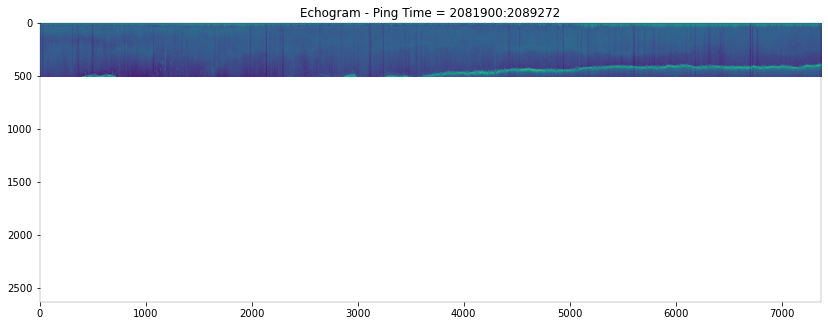

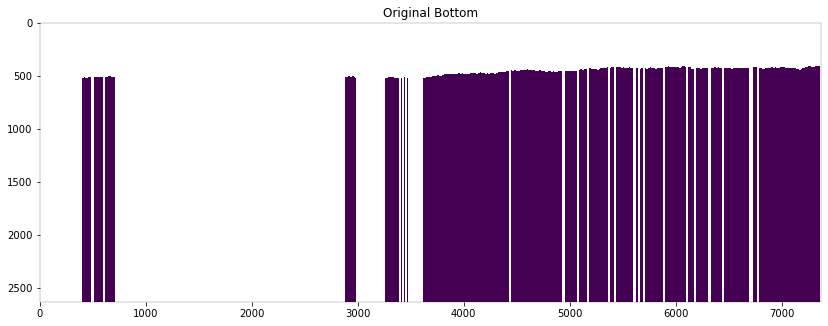

In [24]:
x=2035328
y=148
deneme_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                          idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                          return_numpy=False)
plt.figure(figsize=(14, 12))
plt.title('Echogram - Ping Time = 2081900:2089272')
plt.imshow(db(zarr_grid.sv[0,2081900:2089272,:].values.T))
plt.show()

#plt.title('Get Seabed Mask Function Output')
#plt.imshow(deneme_mask.values.T)
#plt.colorbar()

plt.figure(figsize=(14, 12))
plt.title('Original Bottom')
plt.imshow(zarr_bottom.bottom_range[2081900:2089272,:].values.T)
plt.show()

mean background Sv = -59.758457  median background Sv = -58.255676


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


mean Sandeel Sv = nan  median Sandeel Sv = nan


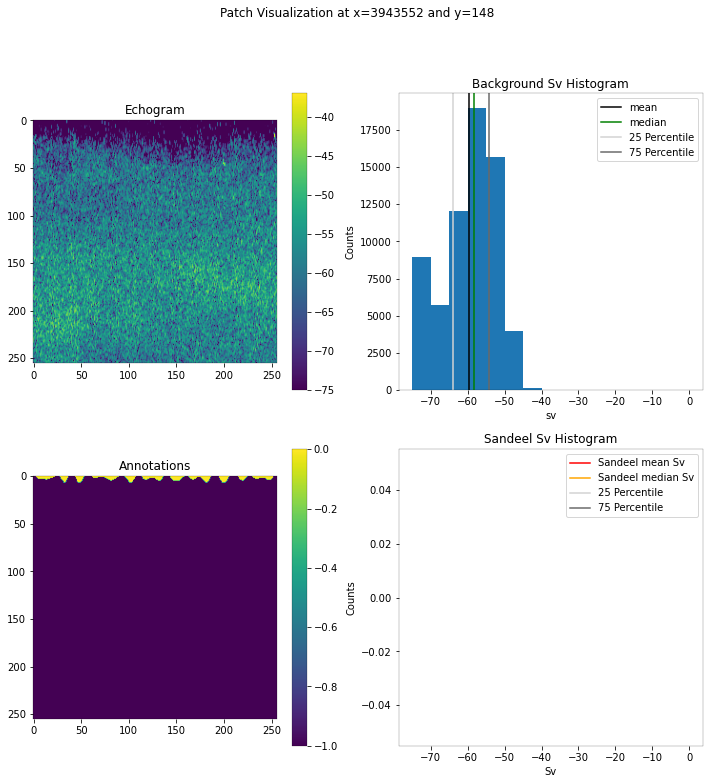

In [25]:
# High Background Values Patch Visualization (max)
max_meanbg = pdata.loc[pdata.idxmax(axis = 0)['mean_bg']]['x'].astype('int')
examp_illustr(survey, x=3943552, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Ping Time, Range, and Vessel Velocity

Median Vessel Speed is 9.0 knots
Mean Vessel Speed is 7.353 knots
Median Ping Time is 0.359 seconds
Mean Ping Time is 0.415 seconds


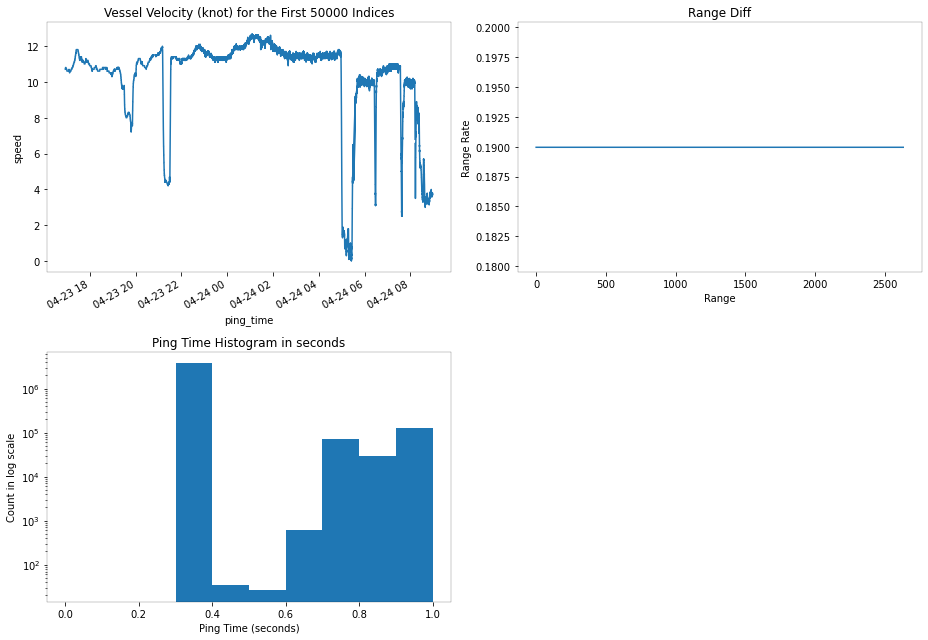

In [26]:
png = np.diff(zarr_grid.ping_time.values).astype('float64')/1000000000

# Vessel Velocity Visualization
print('Median Vessel Speed is '+str(np.nanmedian(zarr_grid.speed.values))+' knots')
print('Mean Vessel Speed is '+str(np.around(np.nanmean(zarr_grid.speed.values), decimals=3))+' knots')
print('Median Ping Time is '+str(np.median(png))+' seconds')
print('Mean Ping Time is '+str(np.around(png.mean(), decimals=3))+' seconds')
frst = 50000
plt.figure(figsize=(13,9))
plt.subplot(2,2,1)
zarr_grid.speed[0:50000].plot()
plt.title('Vessel Velocity (knot) for the First '+str(frst)+' Indices')

plt.subplot(2,2,2)
# Range is constant (0.1899)
plt.plot(np.diff(zarr_grid.range))
plt.title('Range Diff')
plt.xlabel('Range')
plt.ylabel('Range Rate')

# Ping Time Histogram
plt.subplot(2,2,3)
plt.hist(png, log=True, range=(0,1))
plt.title('Ping Time Histogram in seconds')
plt.ylabel('Count in log scale')
plt.xlabel('Ping Time (seconds)')

plt.tight_layout()
plt.show()

# Patches Data Summary Visualizations

In [27]:
# Class Label Assignment
pdata['class'] = 'background'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']==0)
          & (pdata['nop_below_seabed']==0), 'class'] = 'other'
pdata.loc[(pdata['nop_other']==0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']==0), 'class'] = 'sandeel'
pdata.loc[(pdata['nop_other']==0) & (pdata['nop_sandeel']==0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed'
pdata.loc[(pdata['nop_other']==0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_sandeel'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']==0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_other'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']==0), 'class'] = 'sandeel_other'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_sandeel_other'

pdata[pdata['class']=='seabed']

x      y    mean_Sv  mode_Sv     std_Sv  0_Sv      25_Sv  \
25        6528.0  148.0 -72.855858    -75.0   3.619480 -75.0 -75.000000   
26        6784.0  148.0 -70.011757    -75.0   9.431944 -75.0 -75.000000   
27        7040.0  148.0 -70.477646    -75.0   8.139089 -75.0 -75.000000   
28        7296.0  148.0 -70.163849    -75.0  11.548694 -75.0 -75.000000   
29        7552.0  148.0 -68.314285    -75.0   9.539038 -75.0 -75.000000   
...          ...    ...        ...      ...        ...   ...        ...   
30889  3923072.0  404.0 -63.216244    -75.0   5.607733 -75.0 -66.815222   
30891  3923584.0  404.0 -63.763977    -75.0  11.551867 -75.0 -69.797861   
30957  3940480.0  404.0 -68.621567    -75.0   6.949177 -75.0 -75.000000   
30958  3940736.0  404.0 -68.321091    -75.0   5.977858 -75.0 -73.888126   
30959  3940992.0  404.0 -68.569580    -75.0   6.030378 -75.0 -75.000000   

           50_Sv      75_Sv      95_Sv  ...    mean_bg  mode_bg     std_bg  \
25    -75.000000 -71.516905 -65.252331  ... -72.855858    -75.0   3.619480   
26    -74.206787 -68.398067 -54.471683  ... -70.011757    -75.0   9.431944   
27    -74.041340 -68.406666 -59.311984  ... -70.477646    -75.0   8.139089   
28    -75.000000 -70.918573 -46.754709  ... -70.163849    -75.0  11.548694   
29    -70.869812 -65.018791 -55.215256  ... -68.314285    -75.0   9.539038   
...          ...        ...        ...  ...        ...      ...        ...   
30889 -62.693159 -59.241798 -54.751259  ... -63.216244    -75.0   5.607733   
30891 -65.358978 -61.240564 -50.607979  ... -63.763977    -75.0  11.551867   
30957 -70.187187 -64.448448 -56.932788  ... -68.621567    -75.0   6.949177   
30958 -68.983173 -64.316381 -58.182716  ... -68.321091    -75.0   5.977858   
30959 -69.661709 -63.950094 -57.539051  ... -68.569580    -75.0   6.030378   

       0_bg      25_bg      50_bg      75_bg      95_bg     100_bg   class  
25    -75.0 -75.000000 -75.000000 -71.516905 -65.252331  -5.040109  seabed  
26    -75.0 -75.000000 -74.206787 -68.398067 -54.471683  -2.263479  seabed  
27    -75.0 -75.000000 -74.041340 -68.406666 -59.311984  -1.363183  seabed  
28    -75.0 -75.000000 -75.000000 -70.918573 -46.754709  -2.192420  seabed  
29    -75.0 -75.000000 -70.869812 -65.018791 -55.215256  -0.053760  seabed  
...     ...        ...        ...        ...        ...        ...     ...  
30889 -75.0 -66.815222 -62.693159 -59.241798 -54.751259 -41.655811  seabed  
30891 -75.0 -69.797861 -65.358978 -61.240564 -50.607979   0.000000  seabed  
30957 -75.0 -75.000000 -70.187187 -64.448448 -56.932788   0.000000  seabed  
30958 -75.0 -73.888126 -68.983173 -64.316381 -58.182716   0.000000  seabed  
30959 -75.0 -75.000000 -69.661709 -63.950094 -57.539051 -49.036751  seabed  

[12804 rows x 54 columns]

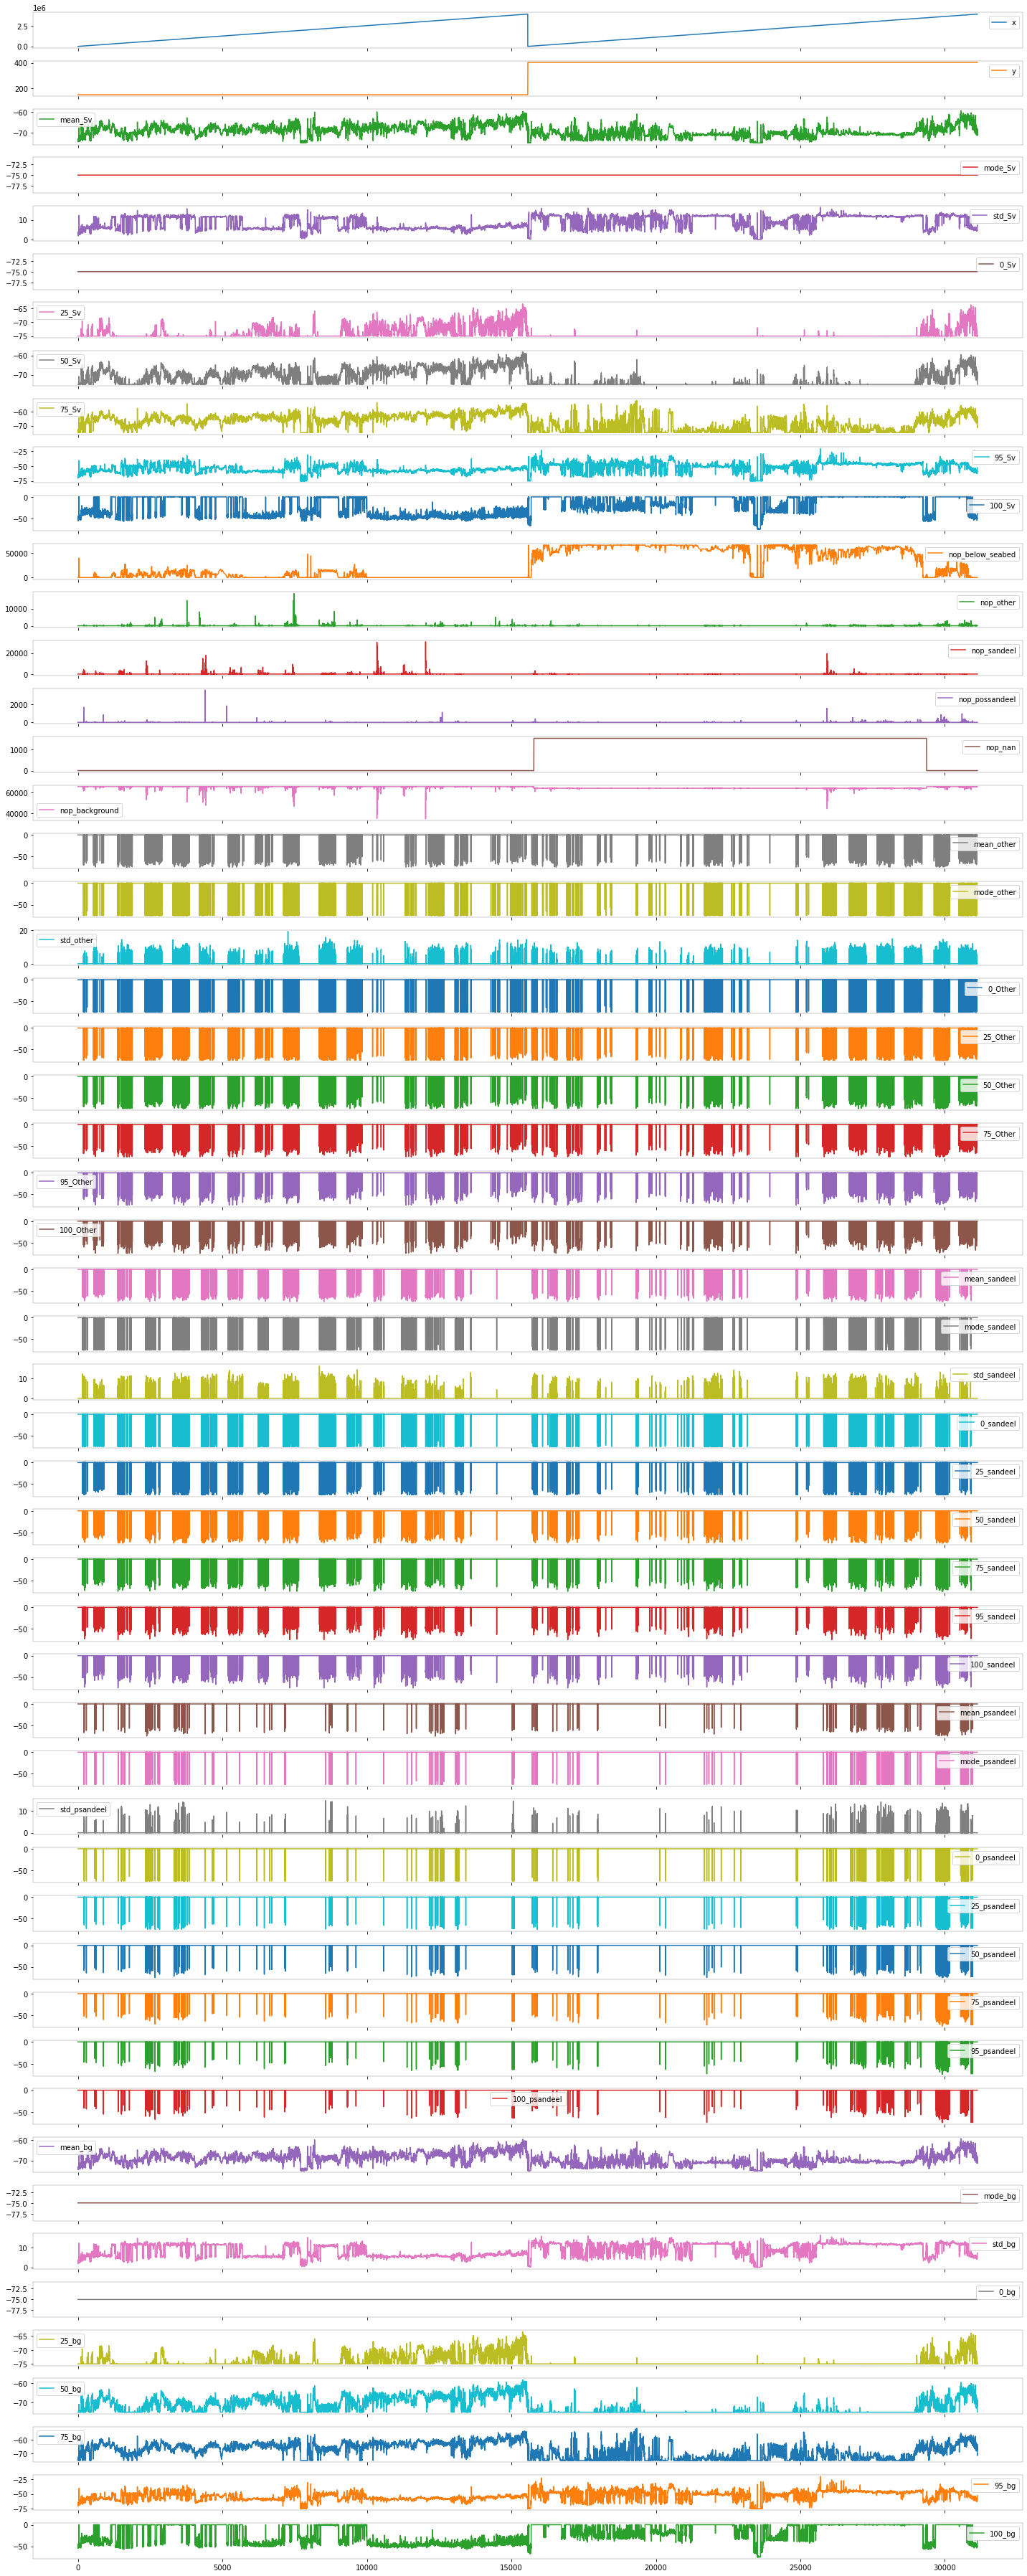

In [103]:
# All Columns Plot
filt_data = pdata[pdata['nop_below_seabed']<6000000]
filt_data.plot(subplots=True, figsize=(20, 50))
plt.tight_layout()
plt.show()

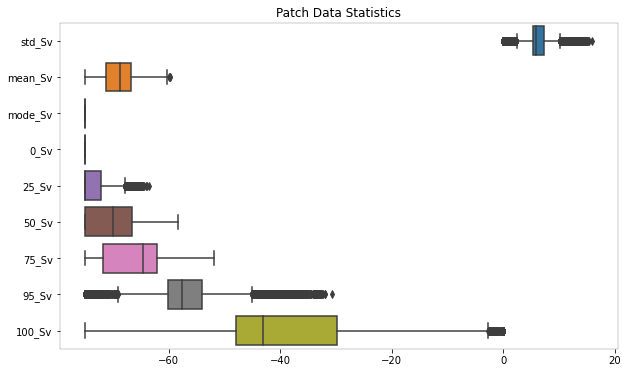

In [28]:
# Boxplot

columns = ['std_Sv', 'mean_Sv', 'mode_Sv', '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv']
plt.figure(figsize=(10,6))
sns.boxplot(data = pdata[pdata['class']=='background'][columns], orient='h')
plt.title('Patch Data Statistics')
plt.show()

# Explanation: Background patches statistical values' box-plot

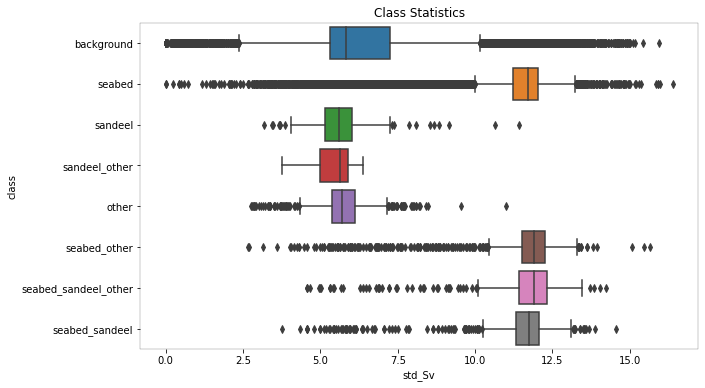

In [29]:
# Boxplot
columns = ['std_Sv', 'mean_Sv', 'mode_Sv', '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv', 'class']
plt.figure(figsize=(10,6))
sns.boxplot(data=pdata[columns], x="std_Sv", y="class")
plt.title('Class Statistics')
plt.show()

# Explanation: Standard deviation box-plot of all patch classes

# Background and Seabed Patch Classes

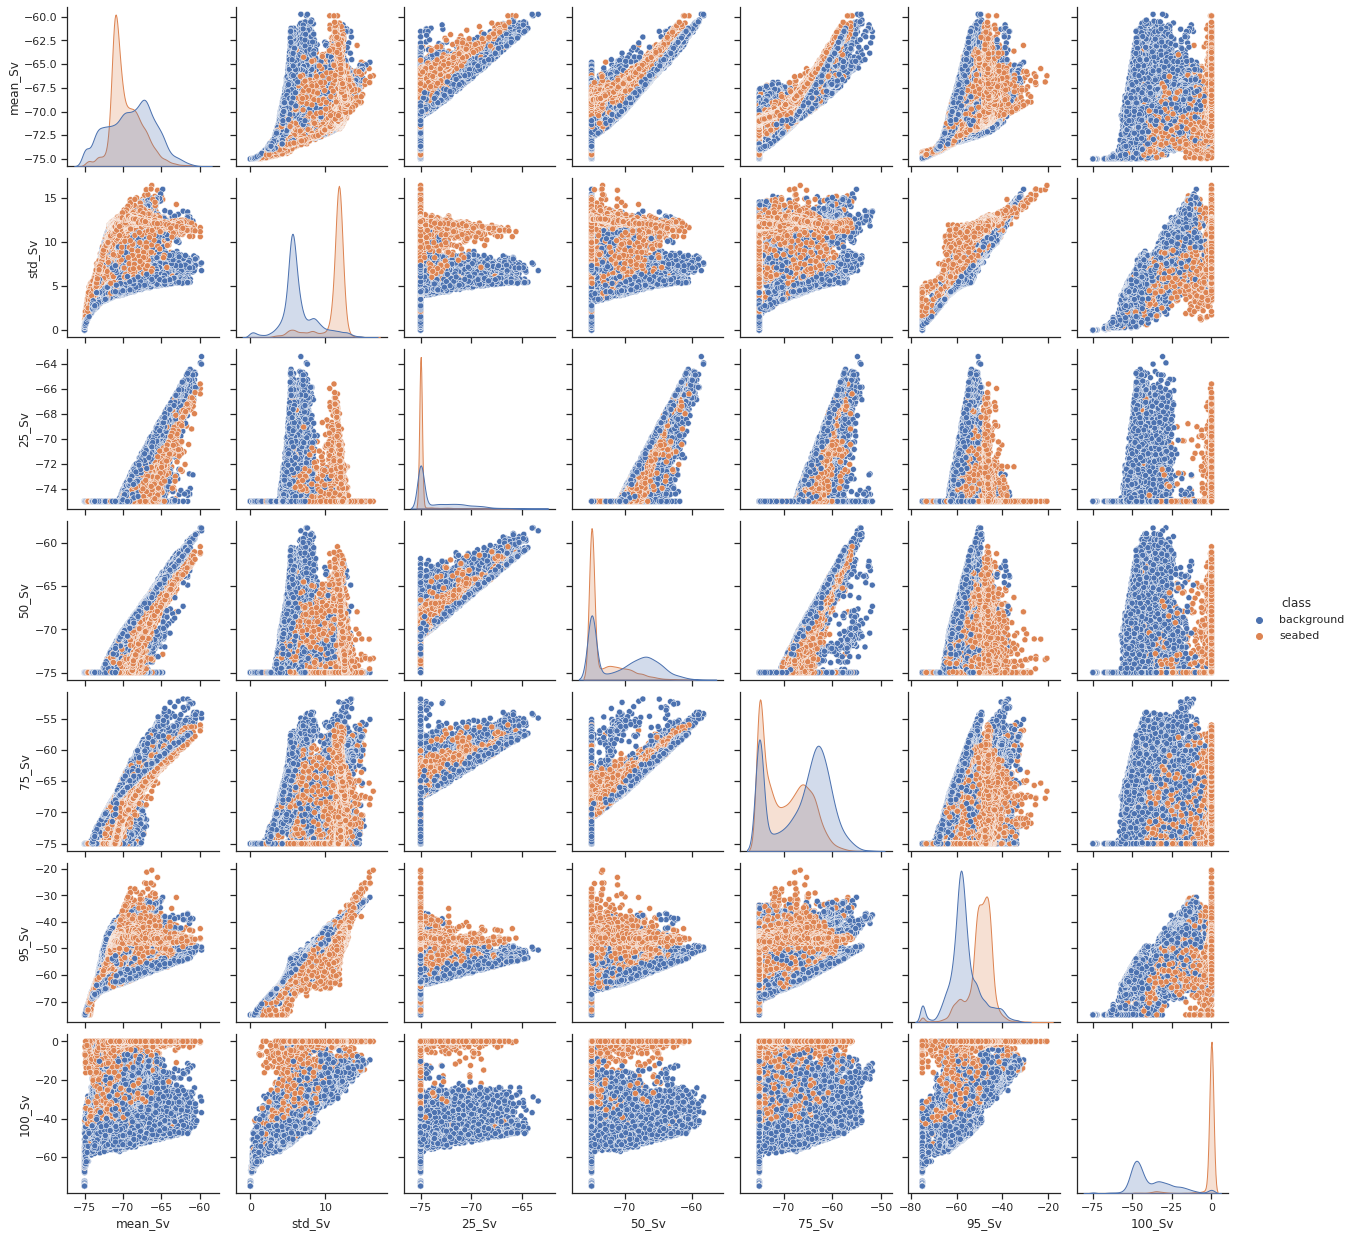

In [153]:
sns.set_theme(style="ticks")
columns = ['mean_Sv', 'std_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv', 'class']
filt = (pdata['class'] == 'background') | (pdata['class'] == 'seabed')
sns.pairplot(pdata[filt][columns], hue="class")

# Explanation: The distribution of the patches with only background, and patches containing seabed
# It seems they are distinguishable ( with std, 95% and 100% percentiles)

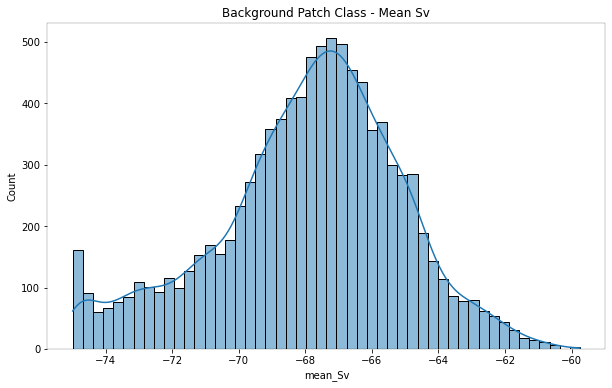

In [30]:
plt.figure(figsize=(10,6))
sns.histplot(pdata[(pdata['class']=='background') & (pdata['nop_nan']==0)]['mean_Sv'], kde=True, stat='count', bins =50)
plt.title('Background Patch Class - Mean Sv')
plt.show()

# Explanation: The background patch class, mean Sv distribution (of the patch)
# It doesn't contain seabed, but contains zooplankton layers

# All Patch Classes

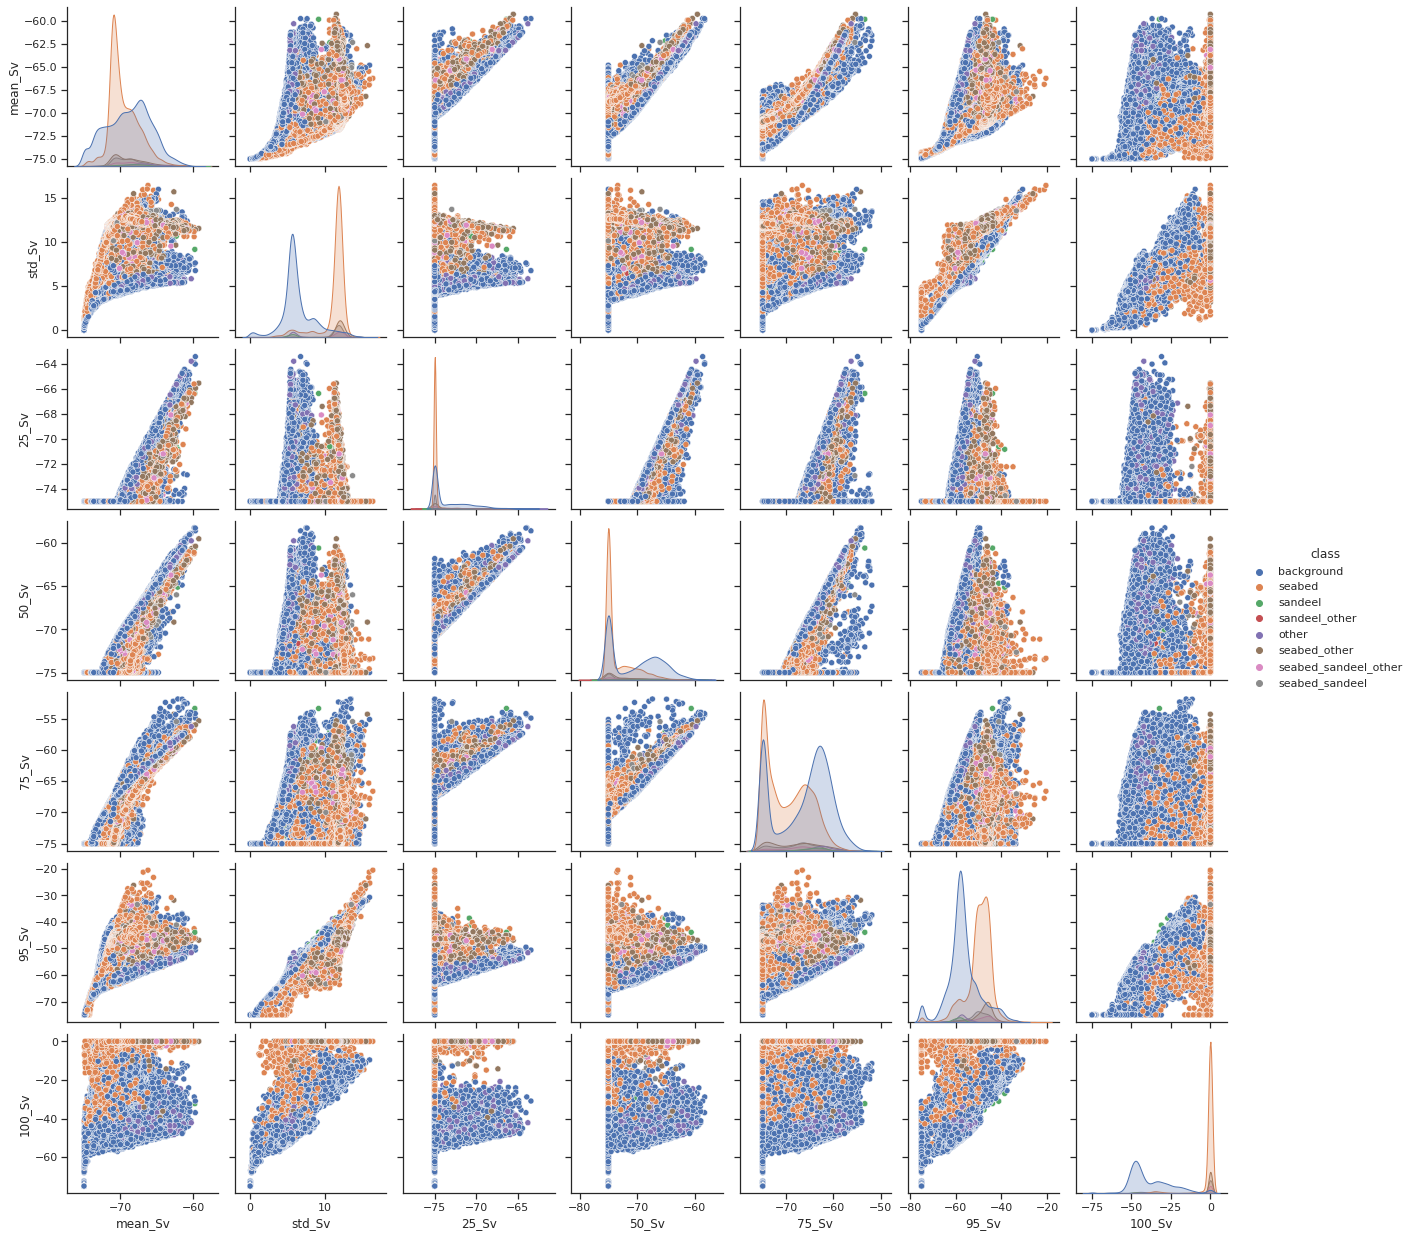

In [131]:
sns.set_theme(style="ticks")
columns = ['mean_Sv', 'std_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv', 'class']
sns.pairplot(pdata[columns], hue="class")

<AxesSubplot:>

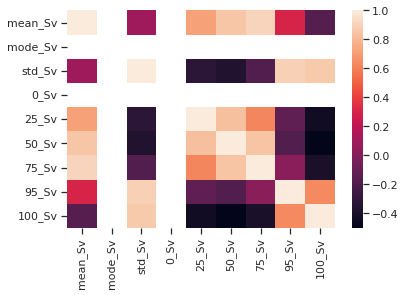

In [155]:
sns.heatmap(pdata[filt][['mean_Sv', 'mode_Sv', 'std_Sv', '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv']].corr())

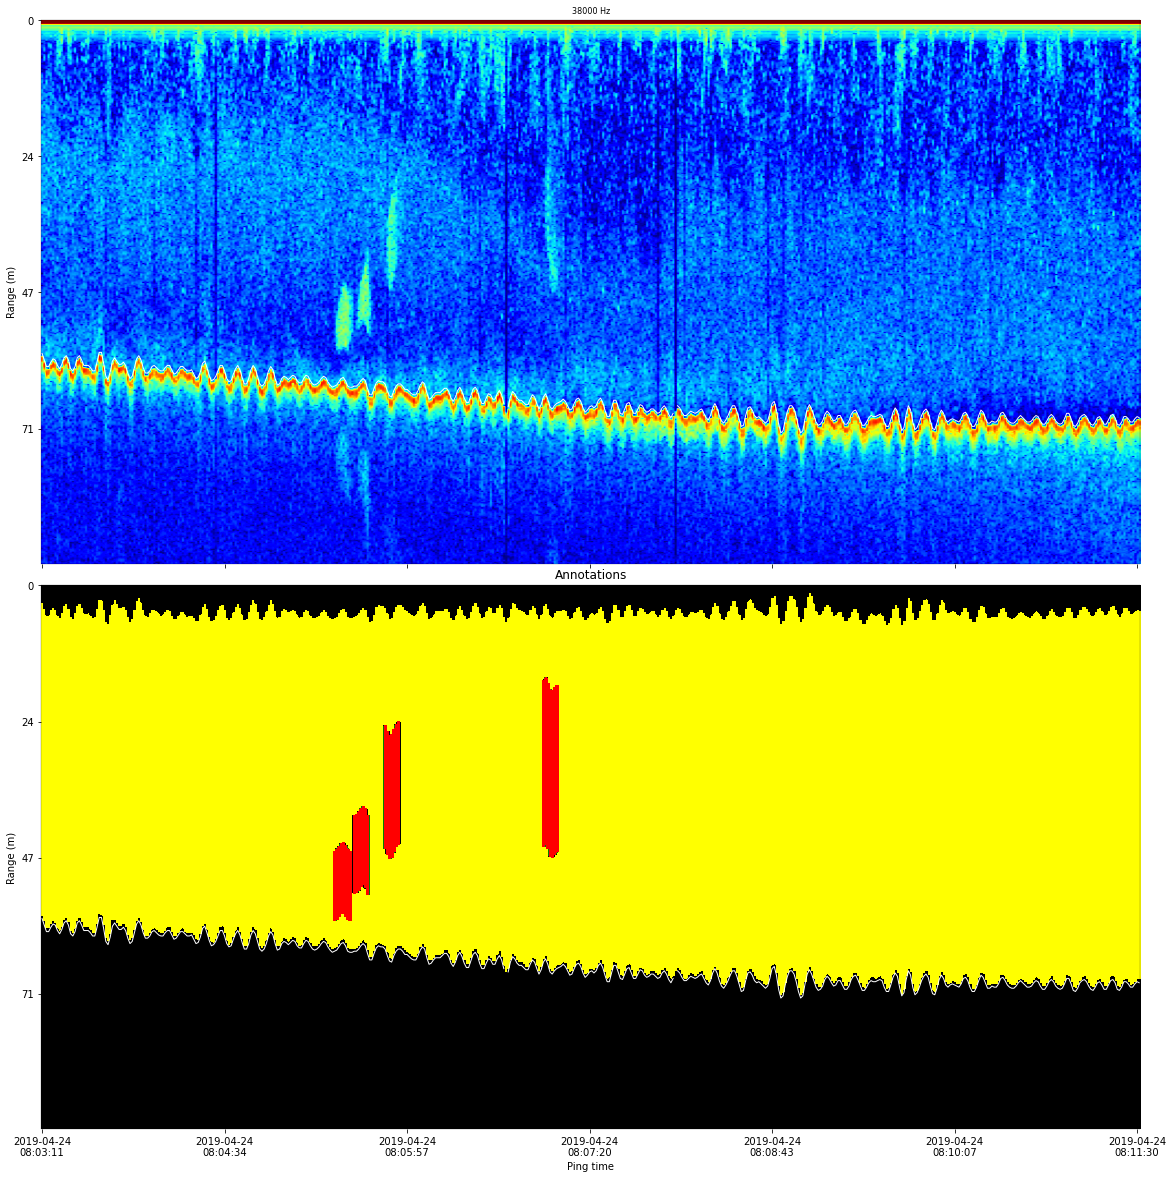

In [92]:
survey.visualize(ping_idx=46776, n_pings=500, range_idx=0, 
                 n_range=500, draw_seabed=True, show_labels=True, frequencies=[38000])